# Surface Mass Balance: XGB 

Import relevant Libaries 

In [ ]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
#%pip update pandas

In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import pyplot

# TS
from statsmodels.tsa.seasonal import seasonal_decompose

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

'/Users/nilsfulde/Desktop/Master_Thesis/scripts'

## Load Stations

In [2]:
# Load Unique Stations
station_list = pd.read_csv(r'../data/promice/stations.csv')

# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
input_path = r'../data/promice/preprocessed/daily/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

In [3]:
#df = df[df['stid'] == 'SCO_L']

In [4]:
stationss = ['KPC_L',
'SCO_L',
'SCO_U',
'THU_L',
'UPE_L',
'UPE_U',
'MIT',
'TAS_L',
'KAN_L',
'NUK_L',
'NUK_U',
'QAS_L',
'QAS_U',]

df = df[df['stid'].isin(stationss)]

## melt onset day / melt end day detection

In [5]:
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
df['Year'] = df['Datetime'].dt.year
df['DayOfYear'] = df['Datetime'].dt.dayofyear

# Initialize new columns with default values
df['first_melt_day'] = False
df['last_melt_day'] = False

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    unique_years = df_station['Year'].unique()
    for year in unique_years:
        # Filter data for the current year
        year_data = df_station[df_station['Year'] == year]

        # Find the first and last melt day
        first_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].min()
        last_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].max()

        # Update the original DataFrame
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == first_melt_day), 'first_melt_day'] = True
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == last_melt_day), 'last_melt_day'] = True

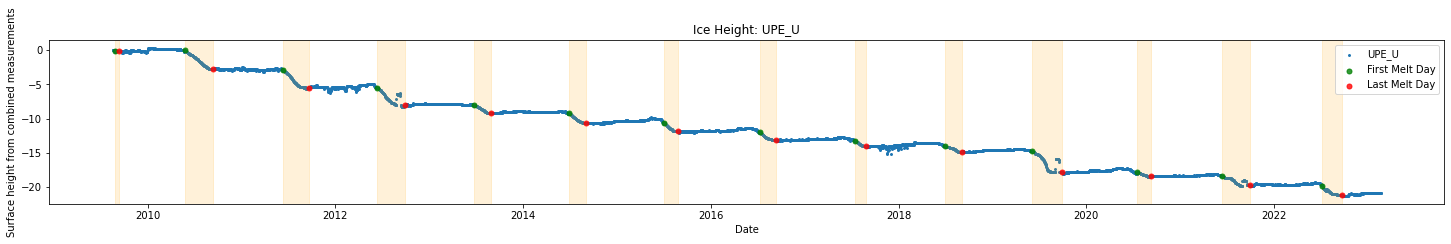

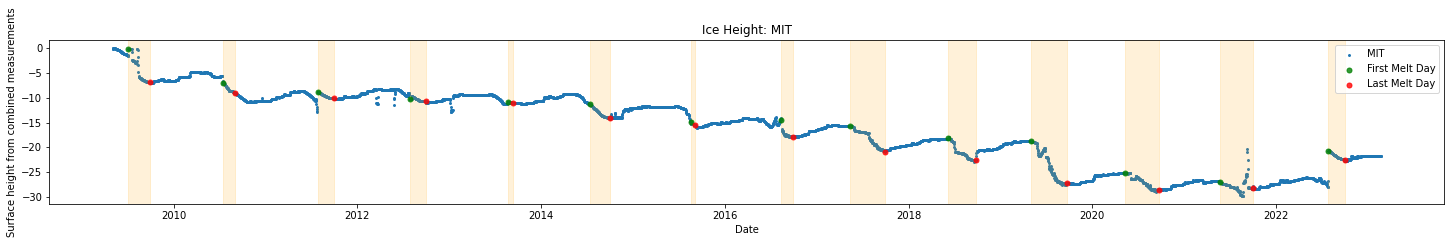

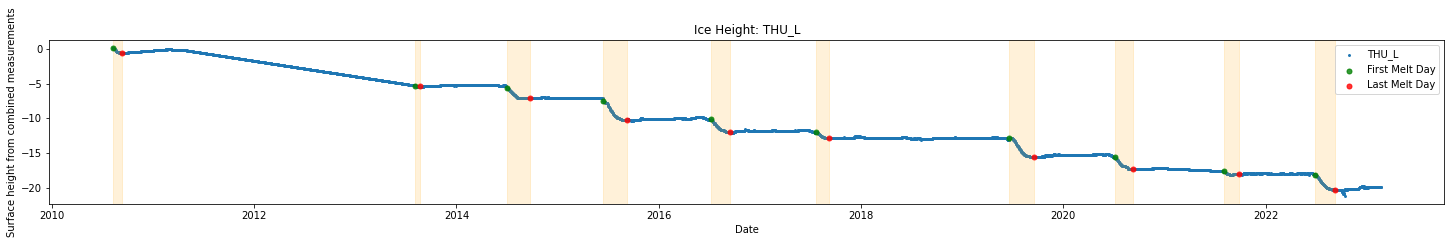

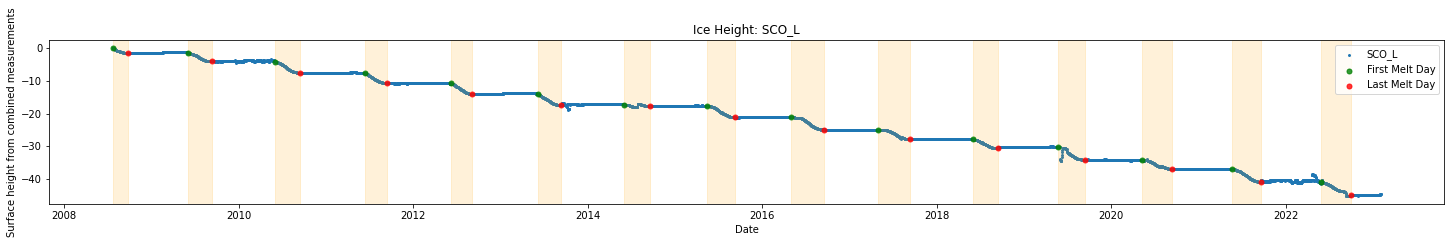

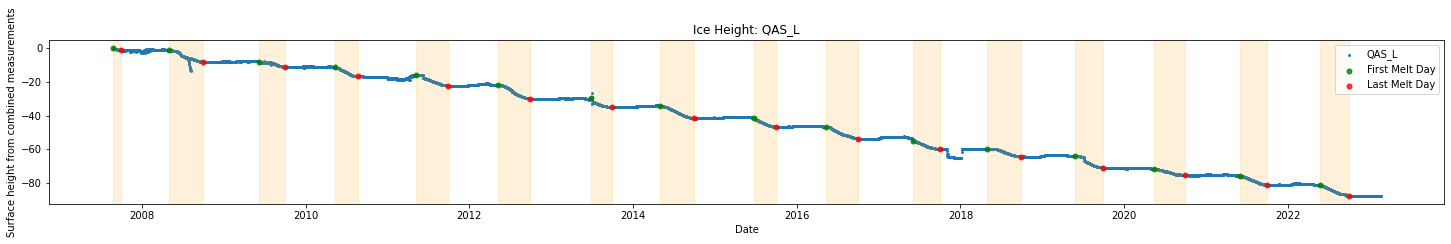

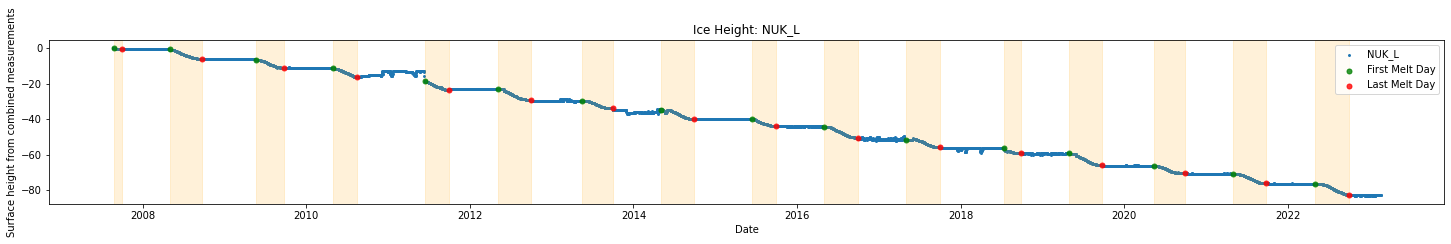

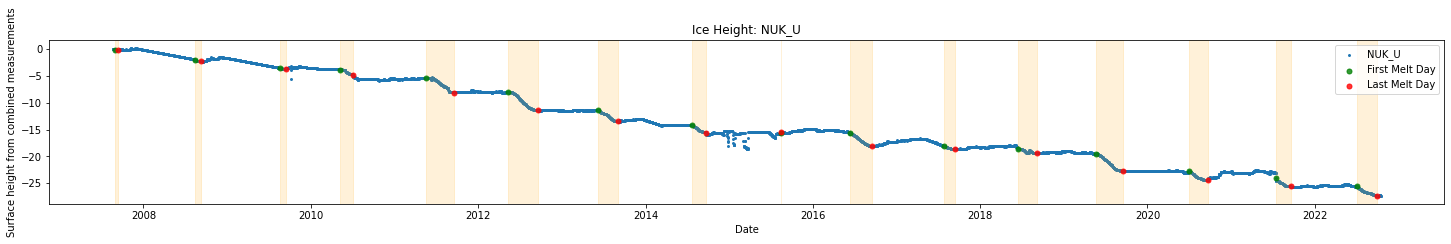

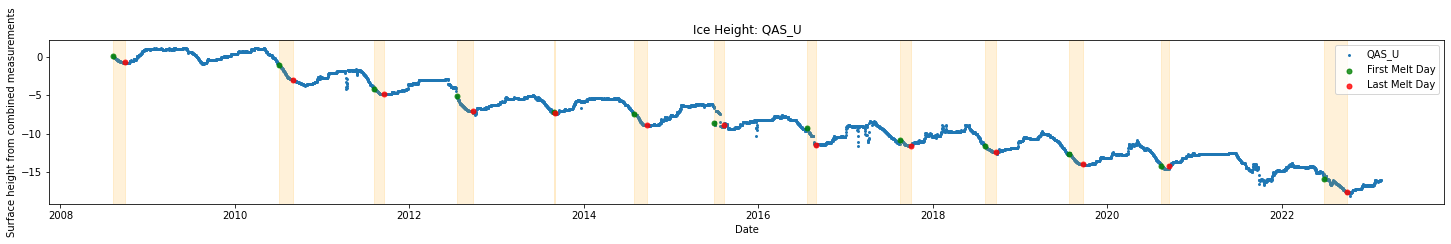

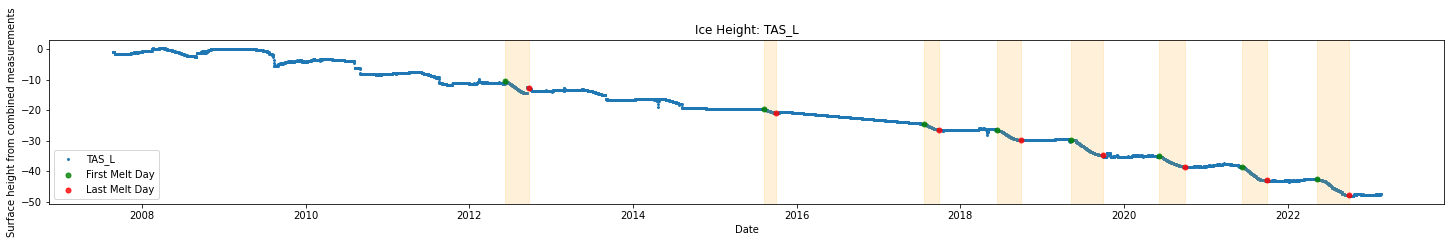

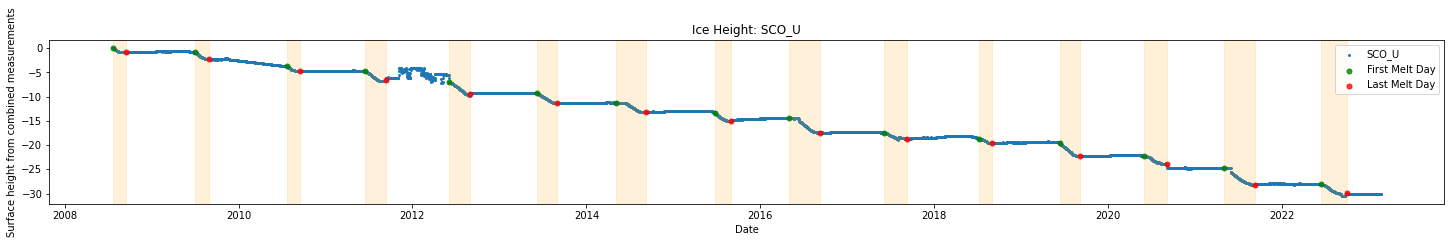

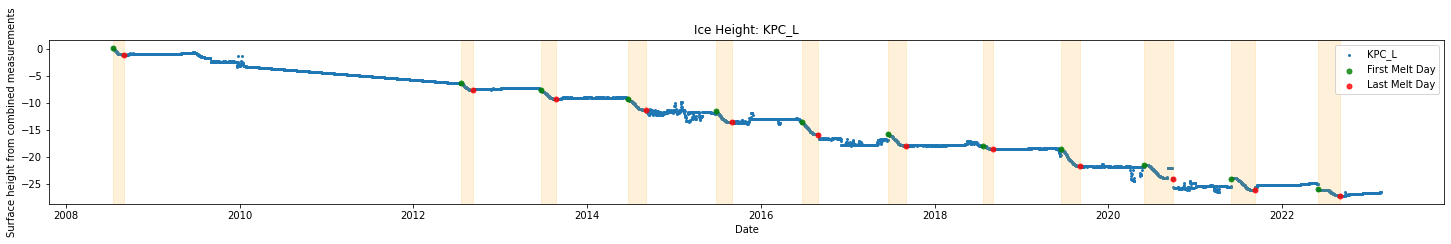

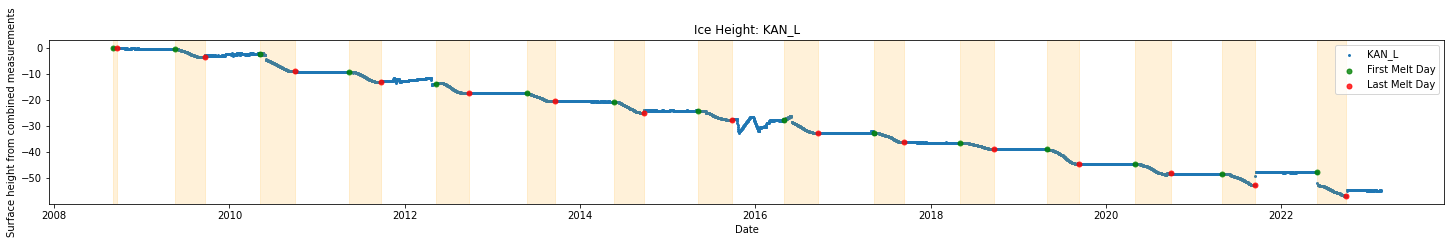

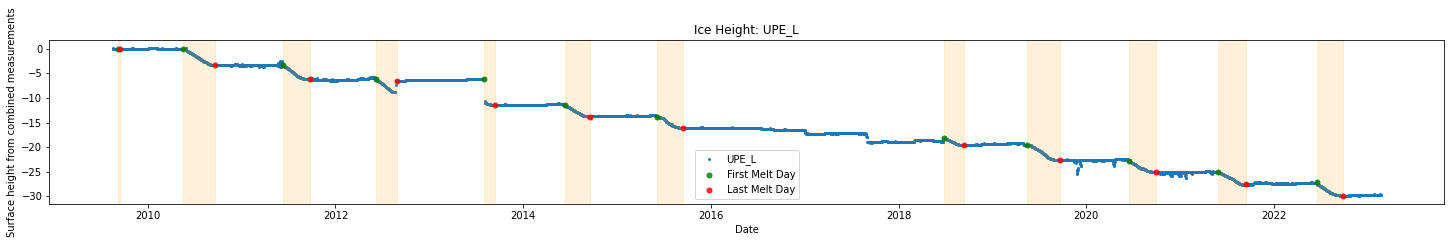

In [6]:
import matplotlib.pyplot as plt
import pandas as pd


for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = station_df[station_df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))
    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['Surface height from combined measurements'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'Surface height from combined measurements'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'Surface height from combined measurements'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Ice Height: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Surface height from combined measurements')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'Surface_Height_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
plt.show()
    

## Time Series Decomposition

In [7]:
# https://datastud.dev/posts/python-seasonality-how-to

In [8]:
# This bit to decompose for each station
df = df[df['stid'] != 'QAS_Lv3']
df = df[df['stid'] != 'Roof_PROMICE']
df = df[df['stid'] != 'LYN_L']
df = df[df['stid'] != 'LYN_T']
df = df[df['stid'] != 'KPC_Lv3']
df = df[df['stid'] != 'KPC_Uv3']
df = df[df['stid'] != 'JAR_O']
df = df[df['stid'] != 'SWC_O']
df = df[df['stid'] != 'THU_L2']
df = df[df['stid'] != 'Roof_GEUS']
df = df[df['stid'] != 'ZAK_Uv3']
df = df[df['stid'] != 'WEG_B']


df = df[df['Surface height from combined measurements'].notna()] 

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    if len(df_station) > 730: 
        exec(f"result_{i} = seasonal_decompose(df_station['Surface height from combined measurements'], model='additive', period=365)")
    else:
        print("Station to remove:", i)
        

In [9]:
# This bit to add decomposition to df and smooth the residual component
ts = pd.DataFrame()

for i in df["stid"].unique().tolist():
    
    # Get data frame for the current station
    df_station = df[df['stid'] == i]

    df_station['observed'] = eval(f"result_{i}.observed")
    df_station['residual'] = eval(f"result_{i}.resid") 
    df_station['seasonal'] = eval(f"result_{i}.seasonal") 
    df_station['trend'] = eval(f"result_{i}.trend")
    df_station['residual_smoothed'] = eval(f"result_{i}.resid") 
    
    # Set the window size and threshold
    window_size = 7
    
    #Outliers based on incremental sum
    threshold_incremental_sum = df_station['residual'].diff().rolling(window_size).sum().quantile(0.8)
    threshold_slope = df_station['residual_smoothed'].diff().abs().quantile(0.8)
        # Calculate the sum of incremental changes over the rolling window
    incremental_sum = df_station['residual'].diff().rolling(window_size).sum()
        # Replace the residuals that exceed the threshold with NaN
    df_station['residual_smoothed'] = df_station['residual']
    df_station.loc[incremental_sum > threshold_incremental_sum, 'residual_smoothed'] = np.nan

    # Outliers based on slope
    slope = df_station['residual_smoothed'].diff().abs()
        # Calculate the 80th percentile of the slopes
    threshold_slope = slope.quantile(0.8)
        # Remove values where the slope is steeper than the threshold
    df_station.loc[slope > threshold_slope, 'residual_smoothed'] = np.nan

    # fill in the NaN values with linear interpolation
    #df_station['residual_smoothed'].interpolate(method='linear', inplace=True)

    # Add new column for seasonal residual
    df_station['seasonal_residual'] = df_station['residual'].fillna(0) + df_station['seasonal']
    
    # Add column for current station
    df_station['stid'] = i
    
    # Append to time series data frame
    ts = ts.append(df_station[['Datetime', 'stid', 'observed', 'residual', 'seasonal', 'trend', 'residual_smoothed', 'seasonal_residual']])

# Merge time series data frame with original data frame
df = pd.merge(df, ts, on=['Datetime', 'stid'], how='left')


In [10]:
# This bit to generate the periods that we want to focus on
df['seasonal'] = df['seasonal'].astype(float)
# create a new column to store the periods
df['Periods'] = ''

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    # iterate over each year in the dataframe
    for year in df_station['Datetime'].dt.year.unique():
        year_data = df_station[df_station['Datetime'].dt.year == year]
        if len(year_data.index) > 300:
            max_index = year_data['seasonal'].idxmax()
            min_index = year_data['seasonal'].idxmin()

            # set the periods in the new column for the maximum value
            df.loc[max_index-5:max_index, 'Periods'] = 'pre_max'
            df.loc[max_index:max_index+6, 'Periods'] = 'post_max'

            # set the periods in the new column for the minimum value
            df.loc[min_index-5:min_index, 'Periods'] = 'pre_min'
            df.loc[min_index:min_index+6, 'Periods'] = 'post_min'
        else:
            continue 

In [11]:
def mround(x, m=5):
    '''Helper method for multiple round'''
    return int(m * round(float(x)/m))

def plot_components(df, station):
    """Plot data for initial visualization
    Args:
        df (pandas dataframe)
    """
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = mround(np.min([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual ]),5)
    ymax = mround(np.max([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymin -= 5
    ymax += 5

    plt.figure(figsize=(20,20))

    #plt.subplot(4,1,1)
    #plt.title("Original Data")
    #plt.ylim(ymin, ymax)
    #plt.plot(df.index, df.observed)

    plt.subplot(4,1,1)
    plt.title("Trend")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.trend)

    plt.subplot(4,1,2)
    plt.title("Seasonal")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.seasonal)

    plt.subplot(4,1,3)
    plt.title("Residual")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual)
    
    plt.subplot(4,1,4)
    plt.title("residual_smoothed")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual_smoothed)

    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    

In [12]:
df["stid"].unique().tolist()

['UPE_U',
 'MIT',
 'THU_L',
 'SCO_L',
 'QAS_L',
 'NUK_L',
 'NUK_U',
 'QAS_U',
 'TAS_L',
 'SCO_U',
 'KPC_L',
 'KAN_L',
 'UPE_L']

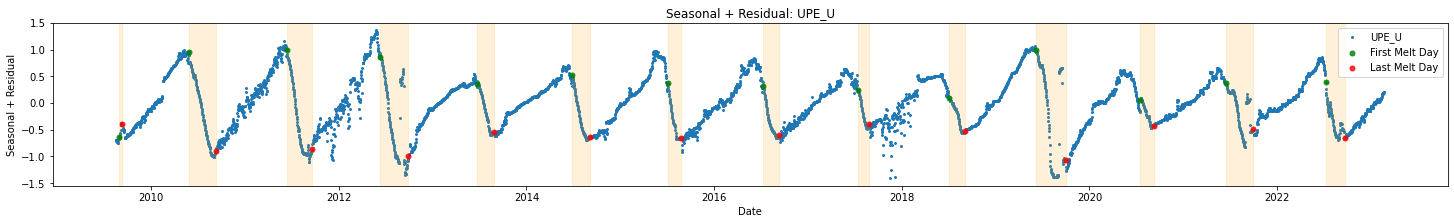

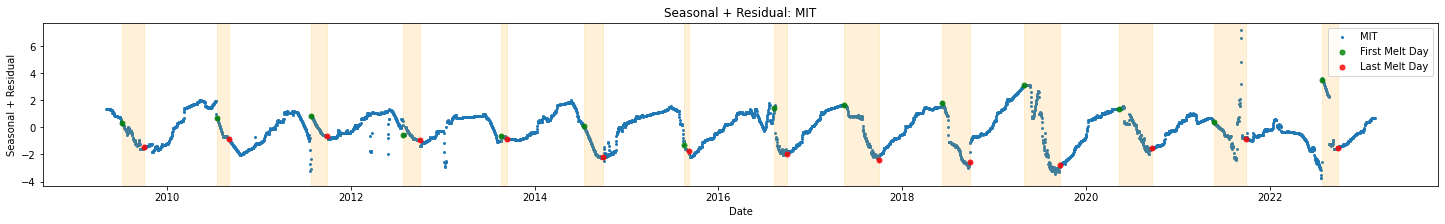

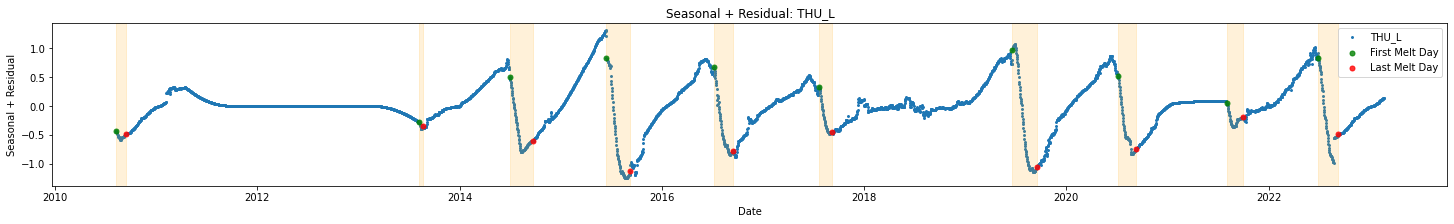

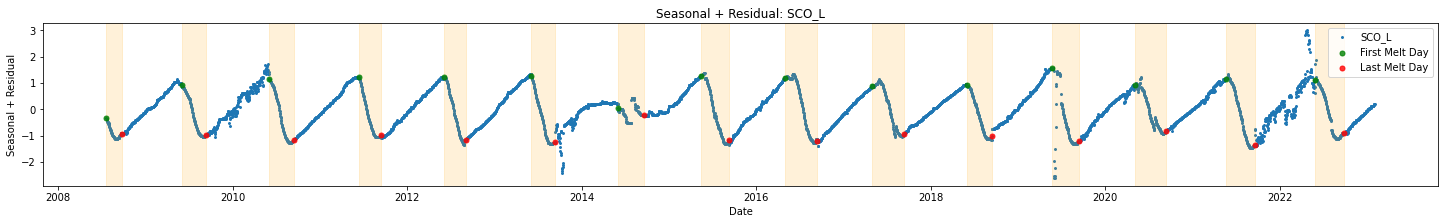

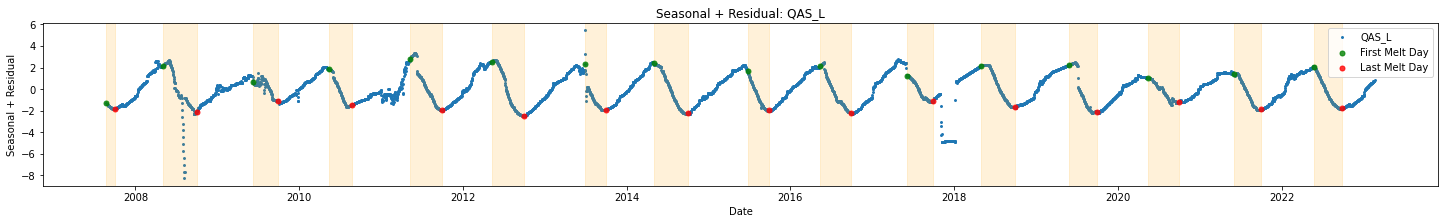

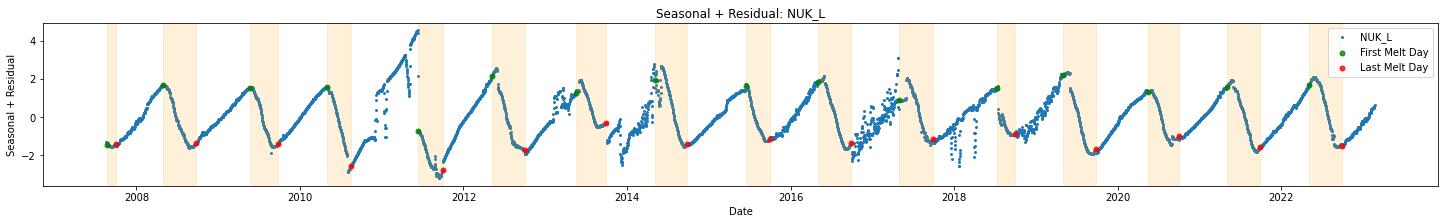

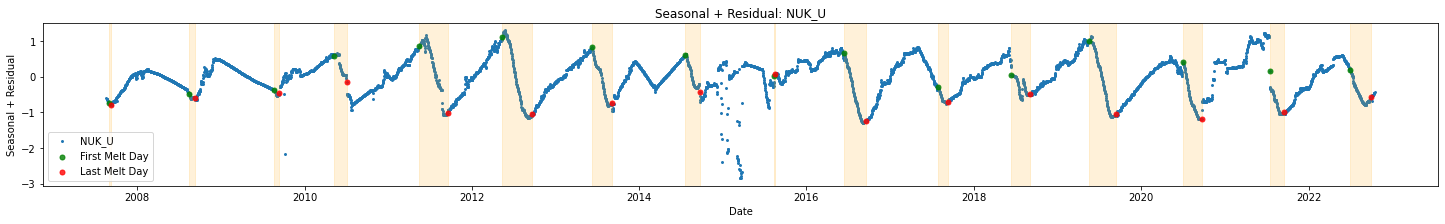

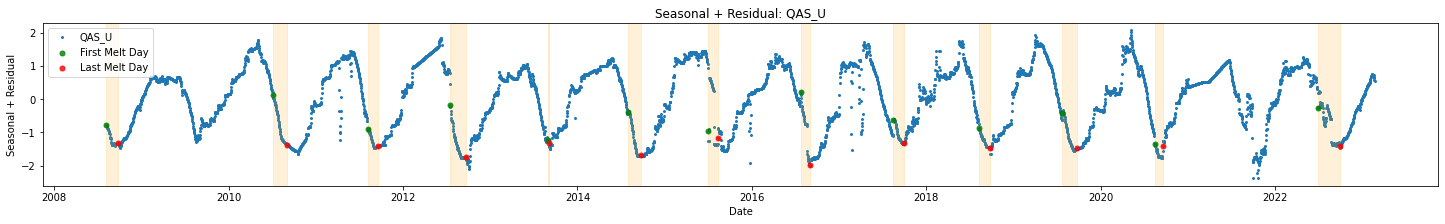

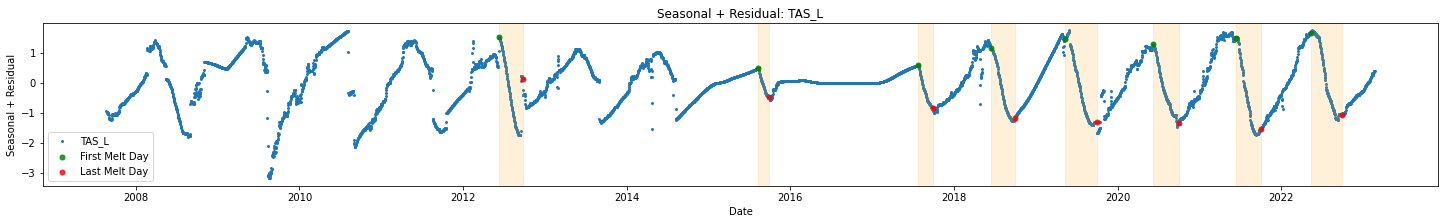

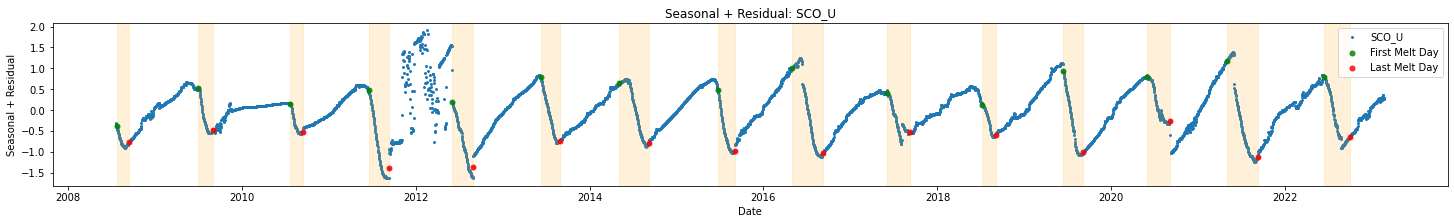

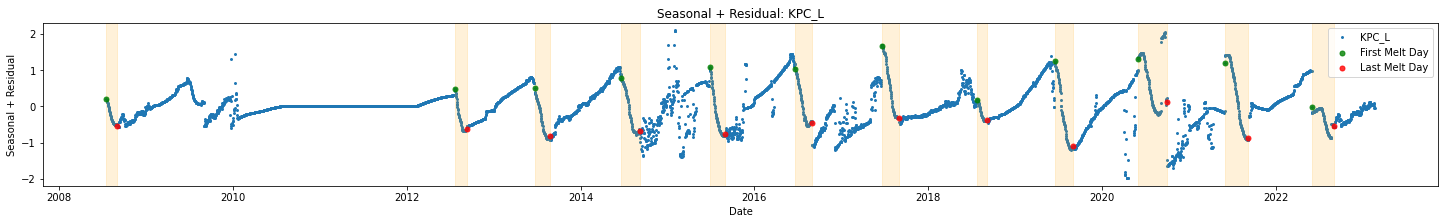

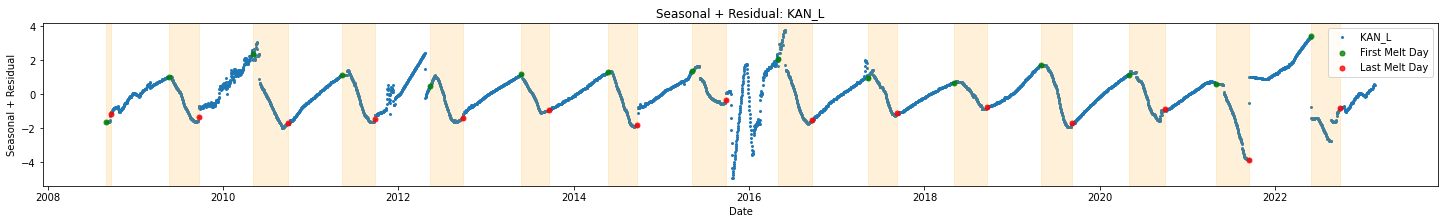

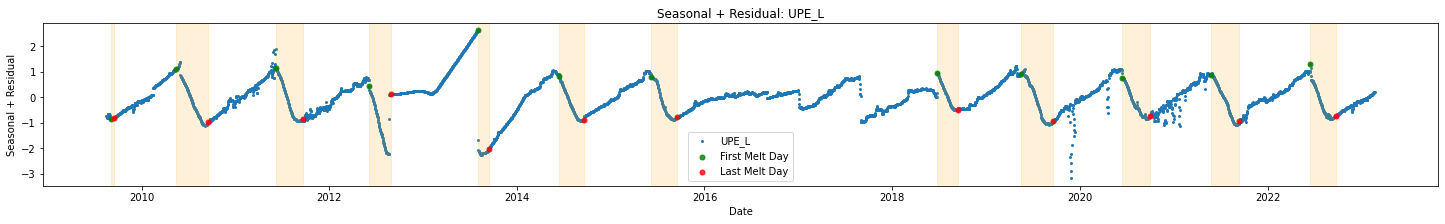

In [13]:
import matplotlib.pyplot as plt
import pandas as pd


for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = df[df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))

    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['seasonal_residual'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'seasonal_residual'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'seasonal_residual'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Seasonal + Residual: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Seasonal + Residual')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'seasonal_residual_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
    
plt.show()


In [14]:
def plt_seasonal_residual(df,station):
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = np.round(np.min([df_axis.seasonal_residual]), 5) - 5
    ymax = np.round(np.max([df_axis.seasonal_residual]), 5) + 5

    plt.figure(figsize=(20,15))

    # Plot the seasonal_residual values
    plt.subplot(4,1,4)
    plt.title("seasonal_residual")
    plt.ylim(ymin, ymax)

    # Plot the pre_max values
   # pre_max_indices = df[df['Periods'] == 'pre_max'].index
   # plt.scatter(pre_max_indices, df.loc[pre_max_indices, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=20 )

    # Plot the post_max values
    #post_max_indices = df[df['Periods'] == 'post_max'].index
    #plt.scatter(post_max_indices, df.loc[post_max_indices, 'seasonal_residual'], c='g', marker='.', label='post_max',s=8)

    # Plot the pre_min values
    #pre_min_indices = df[df['Periods'] == 'pre_min'].index
    #plt.scatter(pre_min_indices, df.loc[pre_min_indices, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=8)

    # Plot the post_min values
    #post_min_indices = df[df['Periods'] == 'post_min'].index
    #plt.scatter(post_min_indices, df.loc[post_min_indices, 'seasonal_residual'], c='g', marker='.', label='post_min',s=8)

    plt.plot(df.index, df.seasonal_residual)#, c = "grey")

#plt_seasonal_residual(df,"SCO_L")


In [15]:
#plot_components(df, 'SCO_L')

## Regression Analysis

##### Set target variable

In [16]:
y = 'seasonal_residual'

In [17]:
len(df)

68587

##### Pre-processing (0.1: Change months to cycle)

In [18]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

#Drop the datetime column
#df.drop(columns=['Datetime'], inplace=True)

In [19]:
len(df)

68587

In [20]:
#from feature_engine.creation import CyclicalFeatures

#cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
#df_wind = df[df['Wind from direction (upper boom)'].notna()]
#cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']])

# Reset the index for both dataframes
#df.reset_index(drop=True, inplace=True)
#cyclical_df.reset_index(drop=True, inplace=True)

# Update the original dataframe with the transformed wind columns
#for col in cyclical_df.columns:
#    df.loc[df_wind.index, col] = cyclical_df[col]


In [21]:
# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
df_wind = df[df['Wind from direction (upper boom)'].notna()] 
cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']]) 

# Reset the index for cyclical_df
cyclical_df.reset_index(inplace=True)

# Merge the original df with the cyclical_df using a left join
df = pd.merge(df.reset_index(), cyclical_df, left_on='index', right_on='index', how='left')

# Drop the 'index' column and reset the index
#df.drop(columns=['index'], inplace=True)


In [22]:
len(df)

68587

##### Pre-processing (1.0: Filter relevant periods)

In [23]:
#df =  df[df['Melting Season'].isin(['pre', 'beginning', 'middle', 'end'])]

#df =  df[df['Ablation'].isin([True])]

In [24]:
df = df[df[y].notna()] 

In [25]:
#df = df.reset_index(drop=True)

In [26]:
# Convert your Datetime column to datetime objects if not already
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Extract year from the Datetime column
df['year'] = df['Datetime'].dt.year

start_day_first = 10
end_day_first = 10
start_day_last = 10
end_day_last = 10

# Define a custom function to filter rows based on the conditions
def filter_melt_days(group):
    first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
    last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

    start_date = first_melt_day - pd.Timedelta(days=start_day_first)
    end_date = last_melt_day + pd.Timedelta(days=end_day_last)

    return group[(group['Datetime'] >= start_date) & (group['Datetime'] <= end_date)]

# Apply the custom function to each group of 'stid' and 'year' and concatenate the results
df = df.groupby(['stid', 'year']).apply(filter_melt_days).reset_index(drop=True)

for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
    
# Define a custom function to extract the expanded indices from the filtered DataFrame
def extract_expanded_indices(filtered_df):
    expanded_indices_first = []
    expanded_indices_last = []

    for (stid, year), group in filtered_df.groupby(['stid', 'year']):
        first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
        last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

        start_date_first = first_melt_day - pd.Timedelta(days=start_day_first)
        end_date_first = first_melt_day + pd.Timedelta(days=end_day_first)

        start_date_last = last_melt_day - pd.Timedelta(days=start_day_last)
        end_date_last = last_melt_day + pd.Timedelta(days=end_day_last)

        expanded_first = group[(group['Datetime'] >= start_date_first) & (group['Datetime'] <= end_date_first)].index
        expanded_last = group[(group['Datetime'] >= start_date_last) & (group['Datetime'] <= end_date_last)].index

        expanded_indices_first.extend(expanded_first)
        expanded_indices_last.extend(expanded_last)

    return expanded_indices_first, expanded_indices_last

# Extract the expanded indices for first and last melt days
expanded_indices_first, expanded_indices_last = extract_expanded_indices(df)


In [27]:
# This bit retrieve the indexes for all melting season categories and remove column from df
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('no_ablation')

for category in ['pre', 'beginning', 'middle', 'end', 'no_ablation']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

for category in ['pre_max', 'post_max', 'pre_min', 'post_min']:
    exec(f"indices_{category} = df[df['Periods'] == '{category}'].index")
    
for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
  

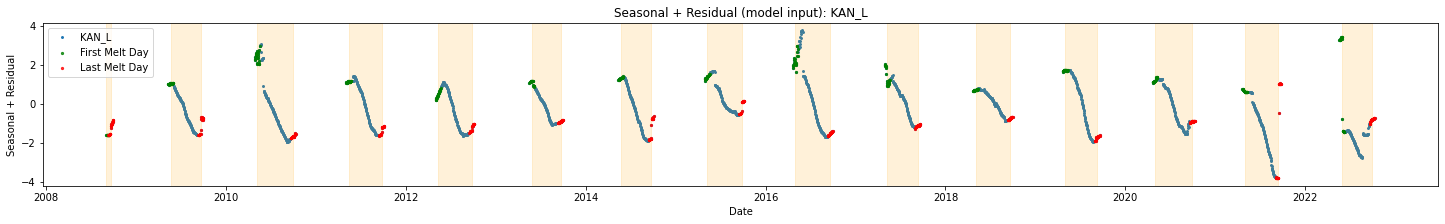

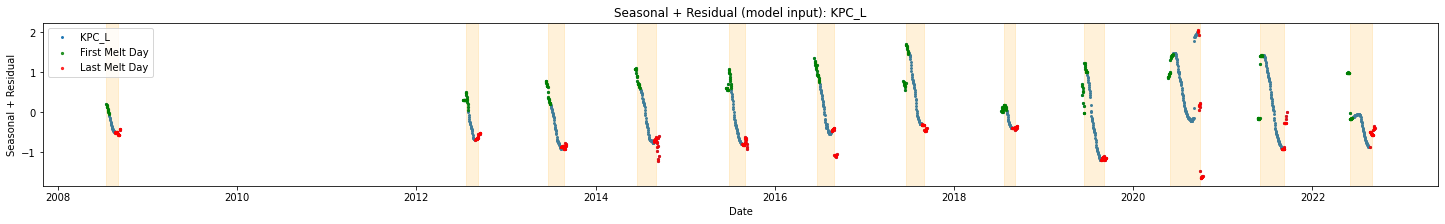

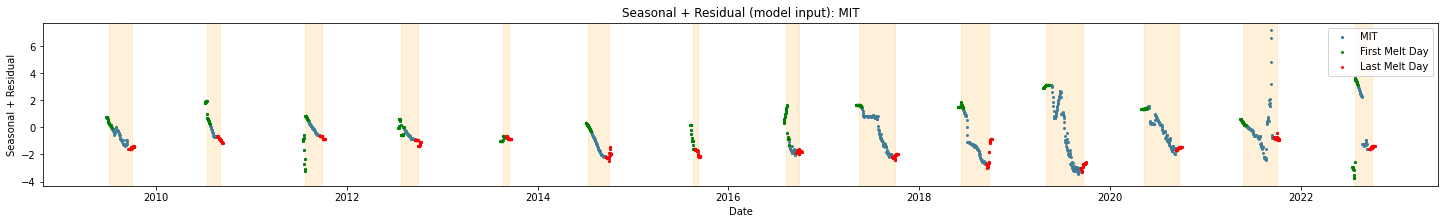

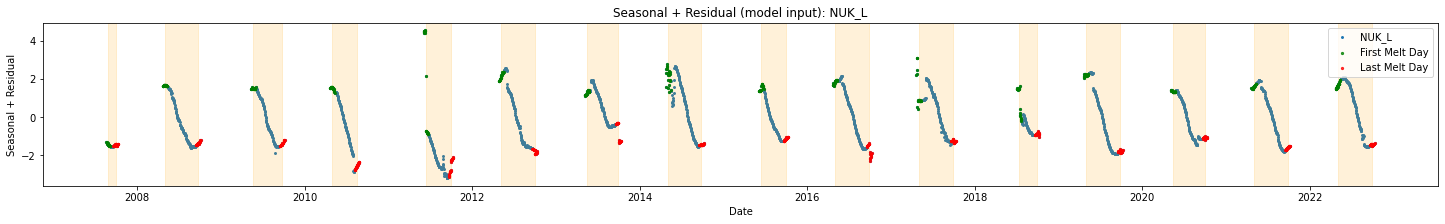

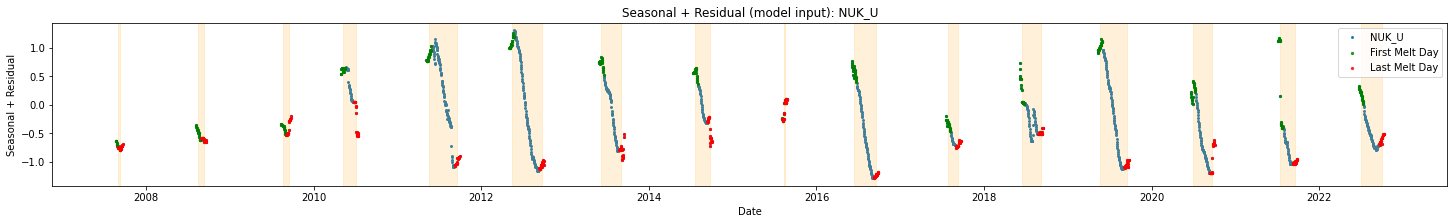

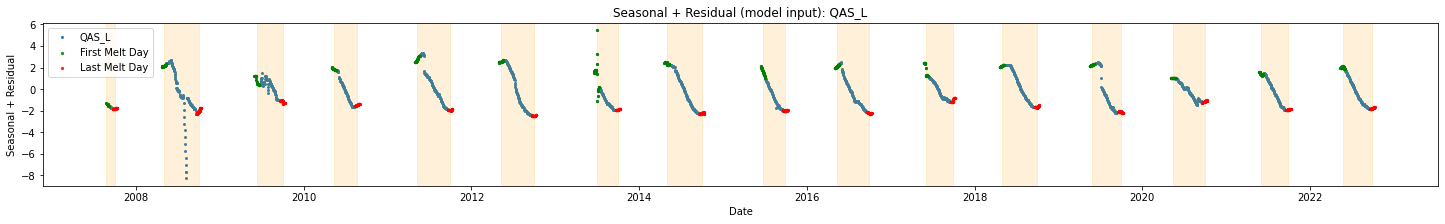

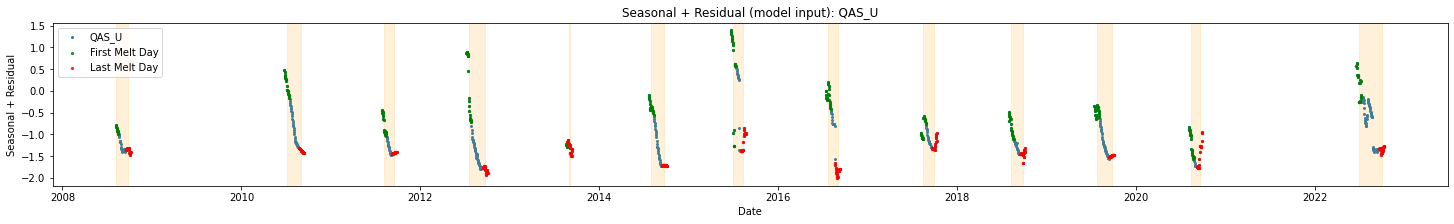

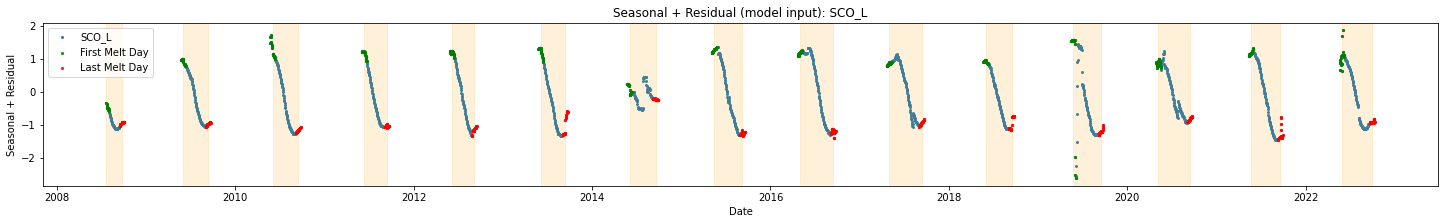

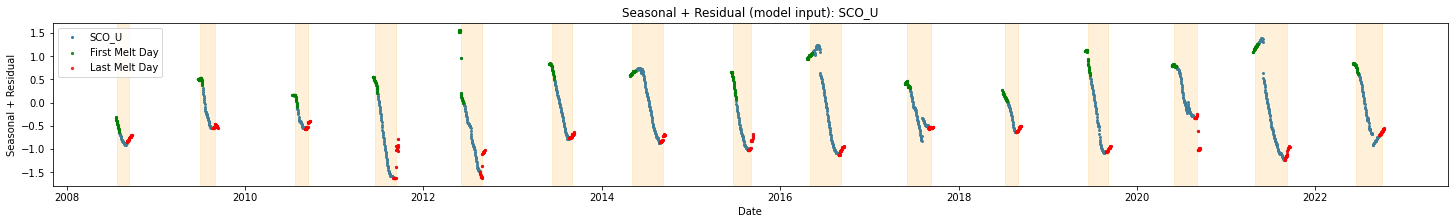

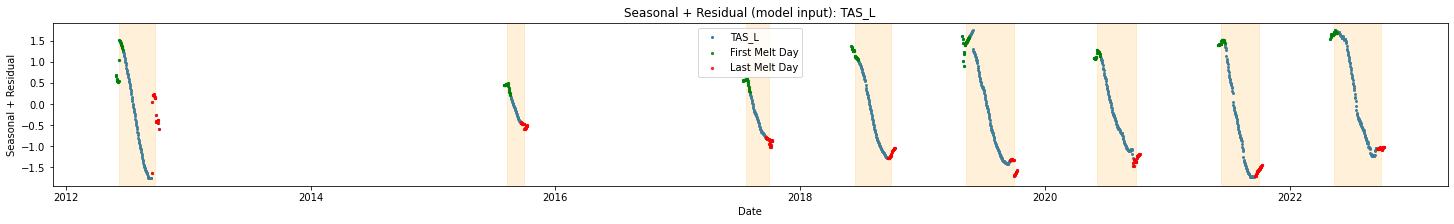

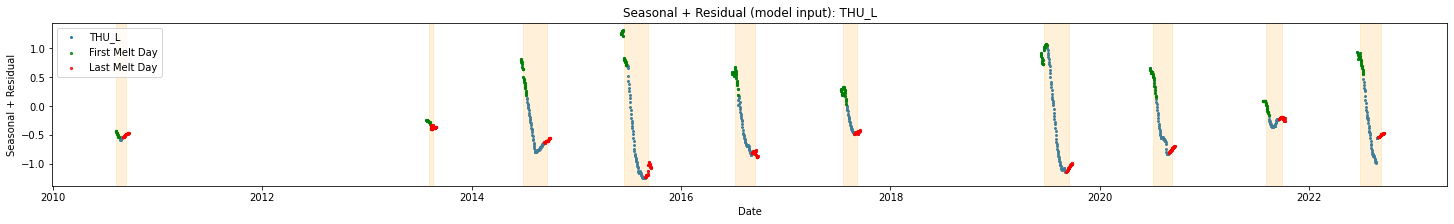

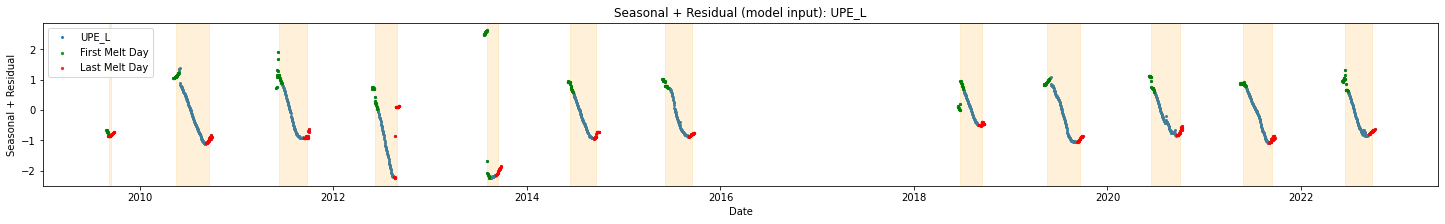

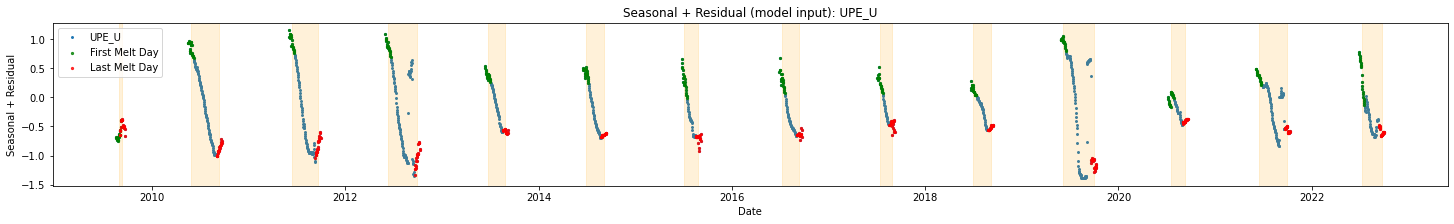

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    # filter the dataframe to only include rows where ablation occurred
   # ablation_df = df[df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))
    station_df = df[df['stid'] == stid]
    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['seasonal_residual'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    first_melt_days = station_df[station_df.index.isin(expanded_indices_first)]
    last_melt_days = station_df[station_df.index.isin(expanded_indices_last)]
    
    # Plot the first melt day values
    #plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'seasonal_residual'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    plt.scatter(first_melt_days['Datetime'], station_df.loc[first_melt_days.index, 'seasonal_residual'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=20)
    
    # Plot the last melt day values
    #plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'seasonal_residual'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)
    plt.scatter(last_melt_days['Datetime'], station_df.loc[last_melt_days.index, 'seasonal_residual'],c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=20)
    
    # set plot title, axis labels and legend
    ax.set_title(f'Seasonal + Residual (model input): {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Seasonal + Residual')
    ax.legend()
    
    # Save the plot in the Downloads folder
    #plot_filename = f'seasonal_residual_model_{stid}.png'
    #plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
plt.show()


##### Pre-processing (2.0: Formatting and transformation)

In [29]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['stid'] = le.fit_transform(df['stid'])
station_names = dict(zip(le.classes_, le.transform(le.classes_)))

In [30]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'ID',
                'Wind from direction (upper boom)',
          #      'Ablation',
                'Melting Season', # We drop melting season later 
                'month',
                'month_sin',
                'month_cos',
                'day', 
                'day_sin',
                'day_cos',
                'hour', 
                'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods',
                'Year',
             #   'first_melt_day',
             #   'last_melt_day',
                'DayOfYear',
              #  'Datetime',
                #'seasonal_residual'
               ]



df = df[[column for column in df.columns if column not in exclude_list]]
data = df.copy()

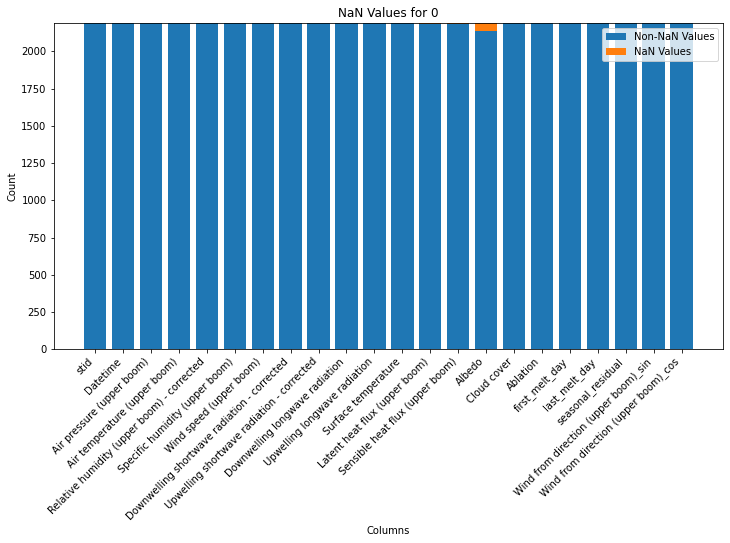

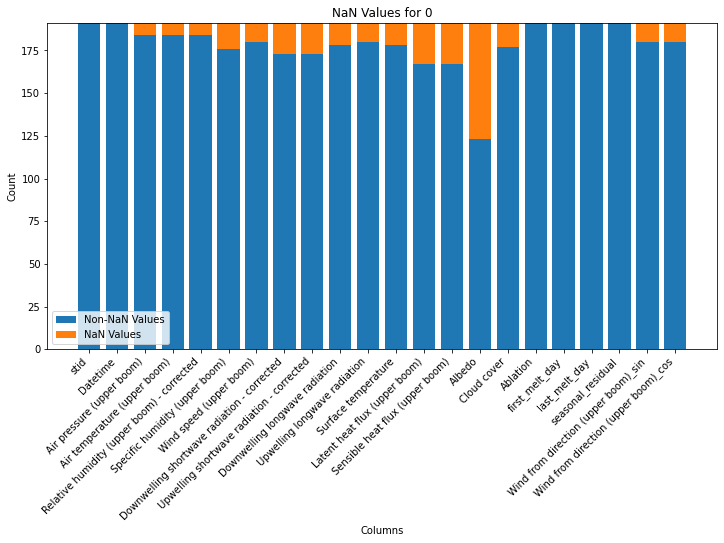

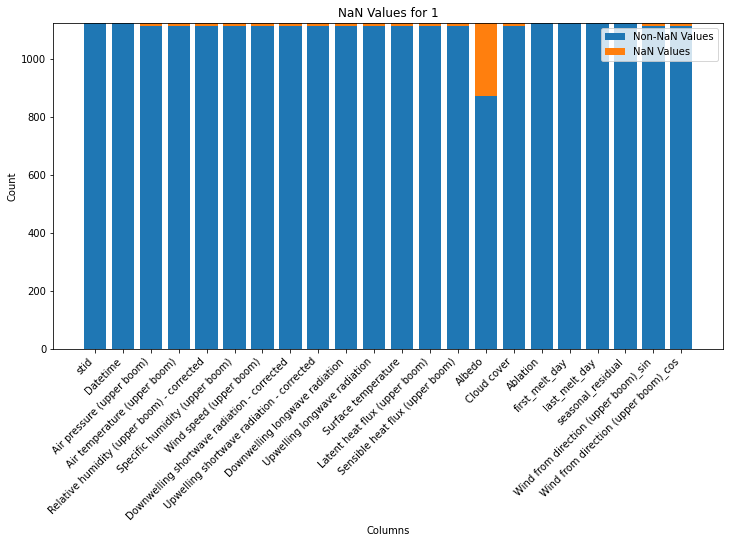

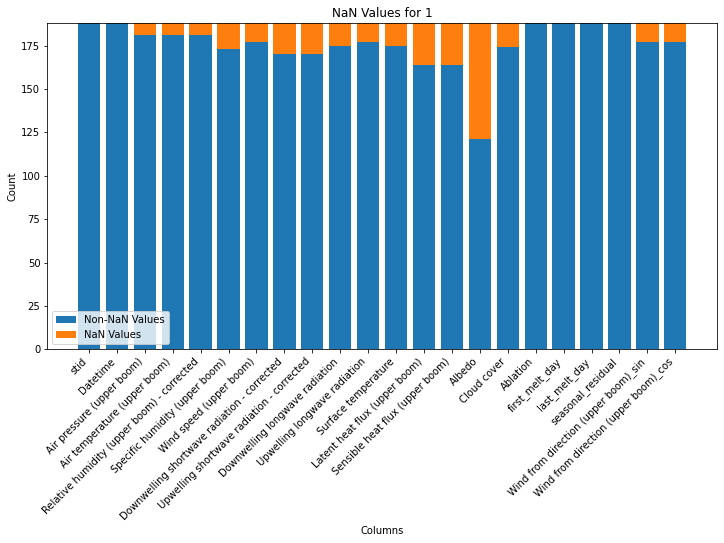

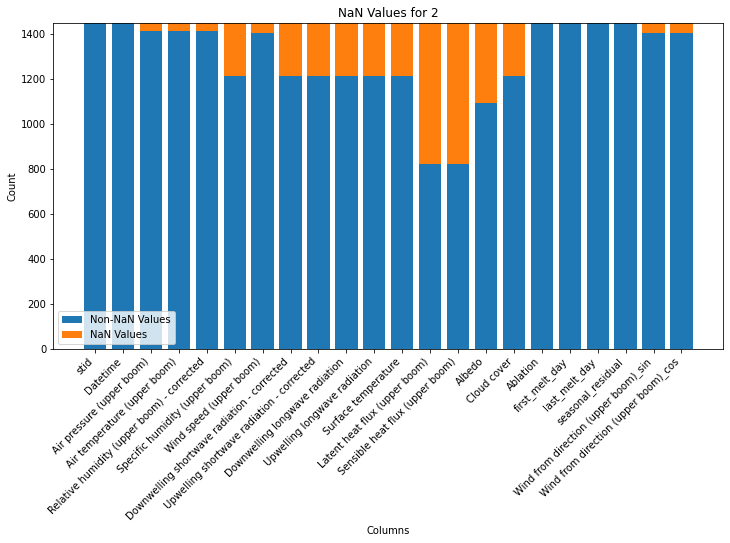

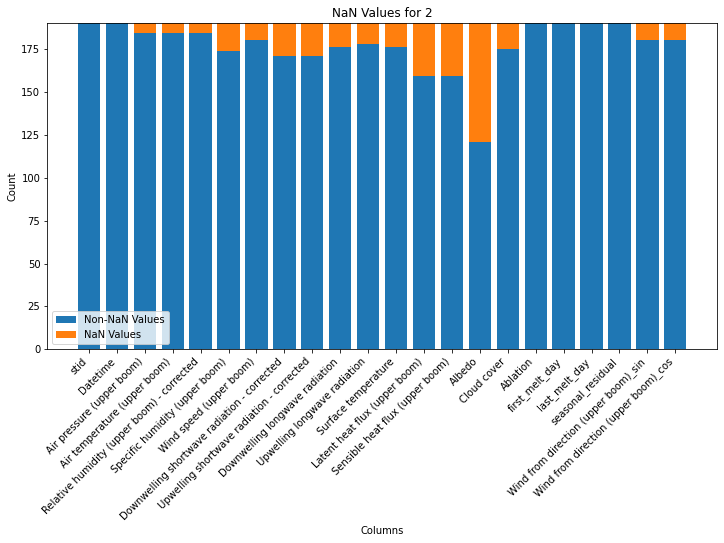

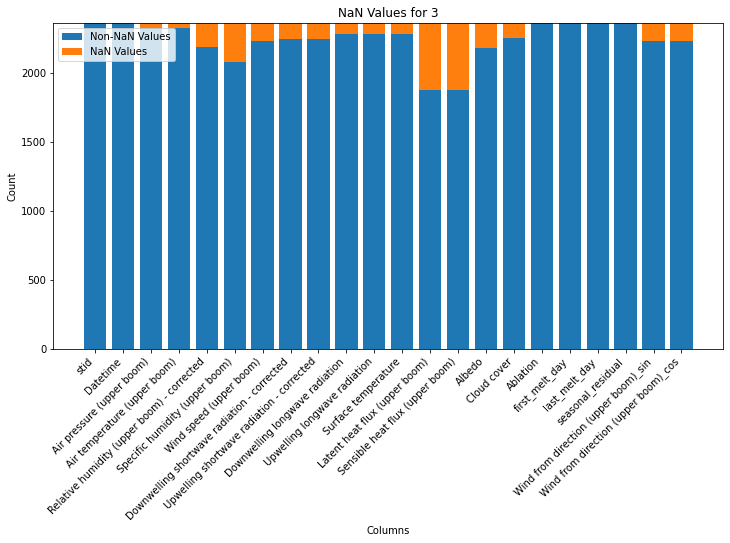

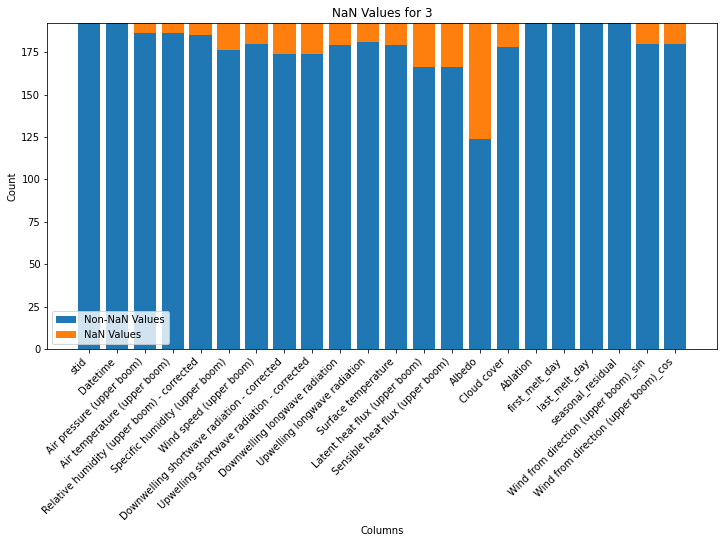

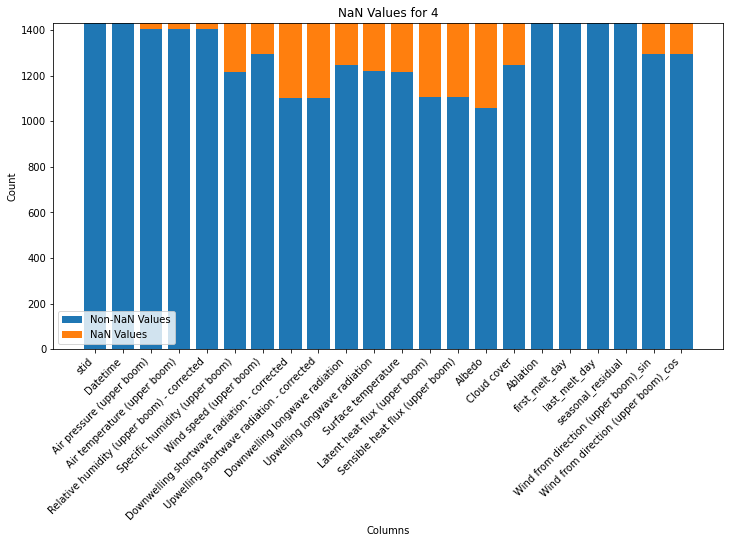

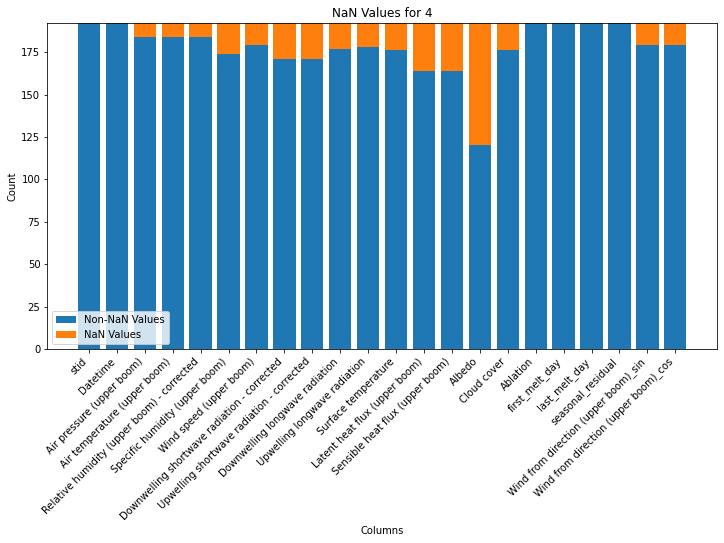

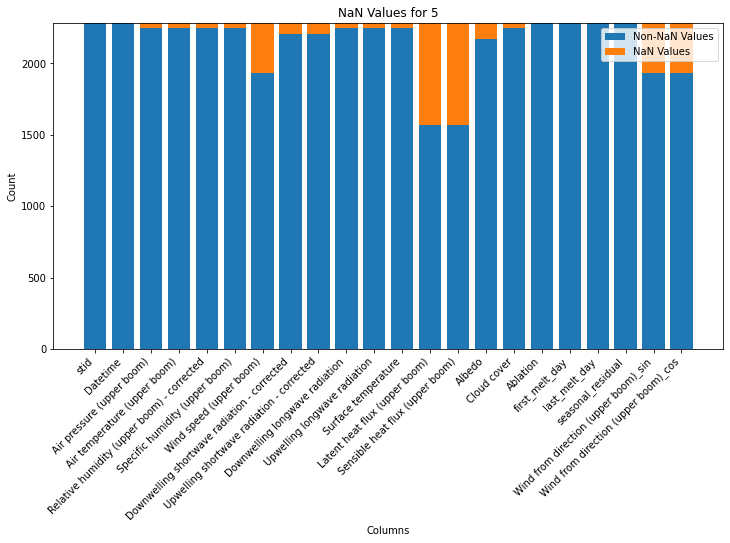

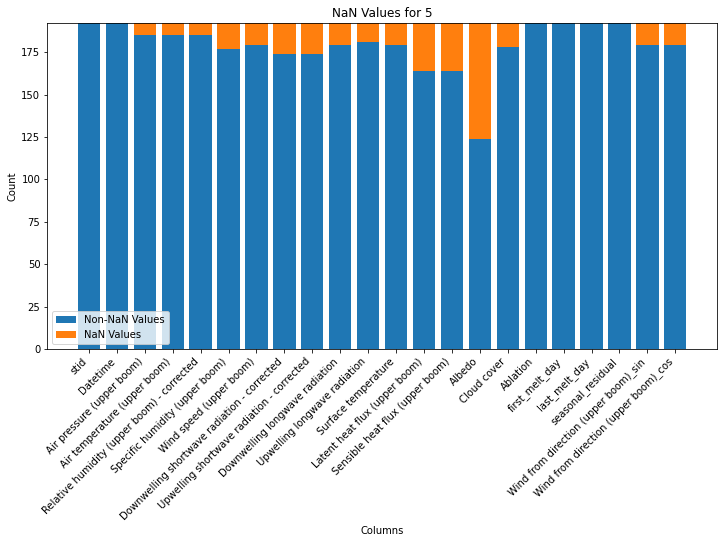

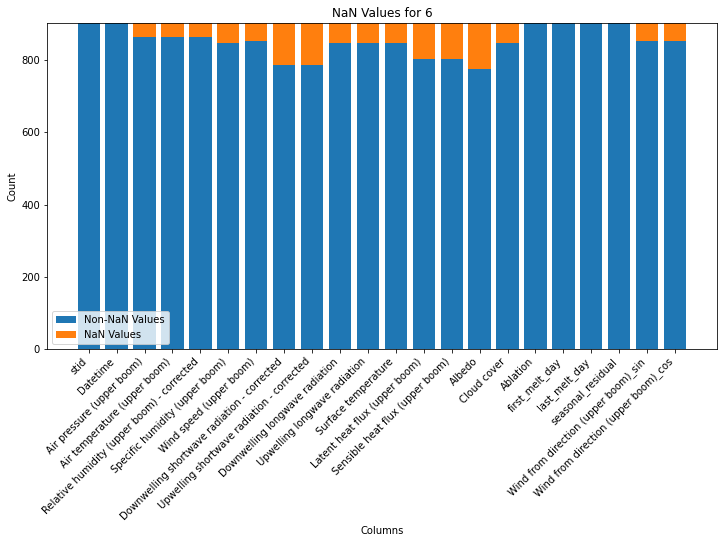

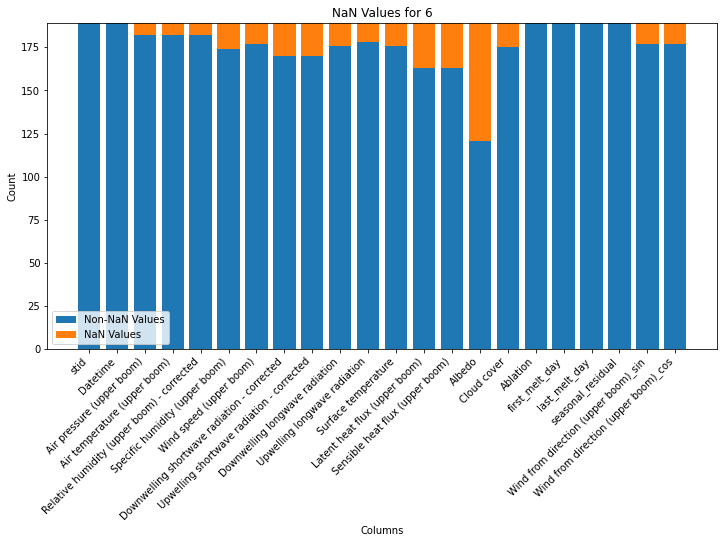

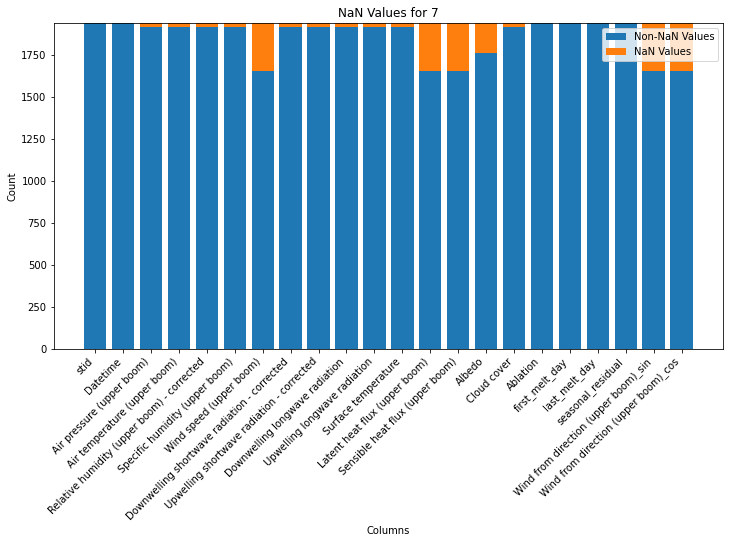

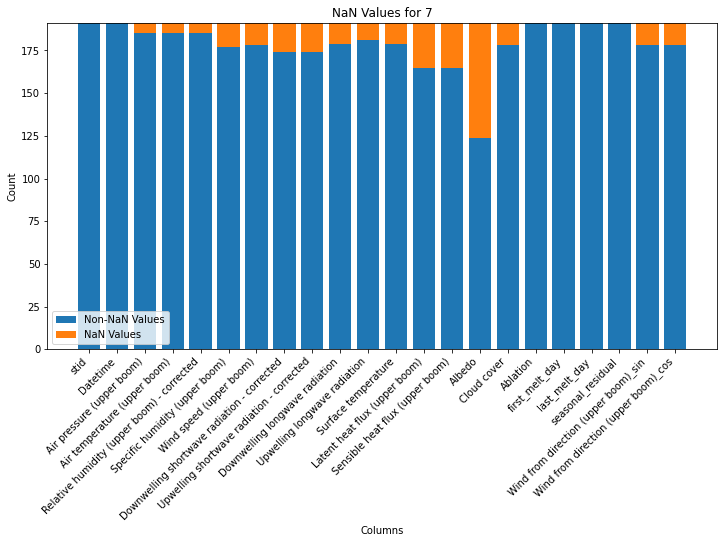

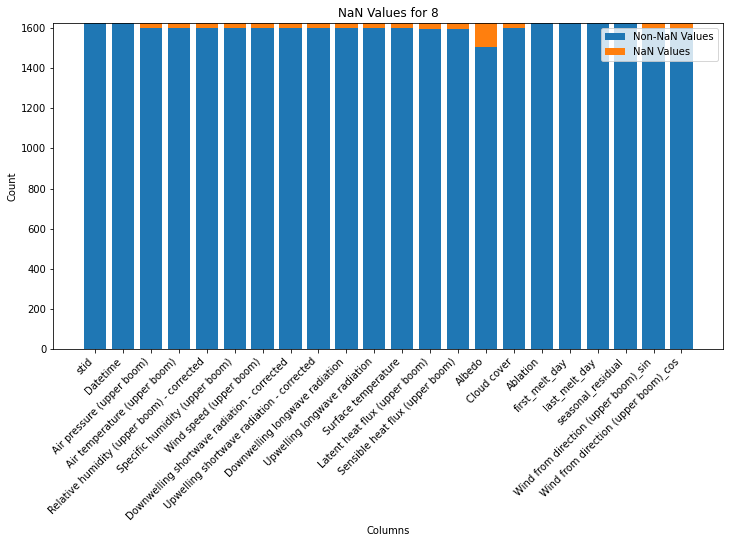

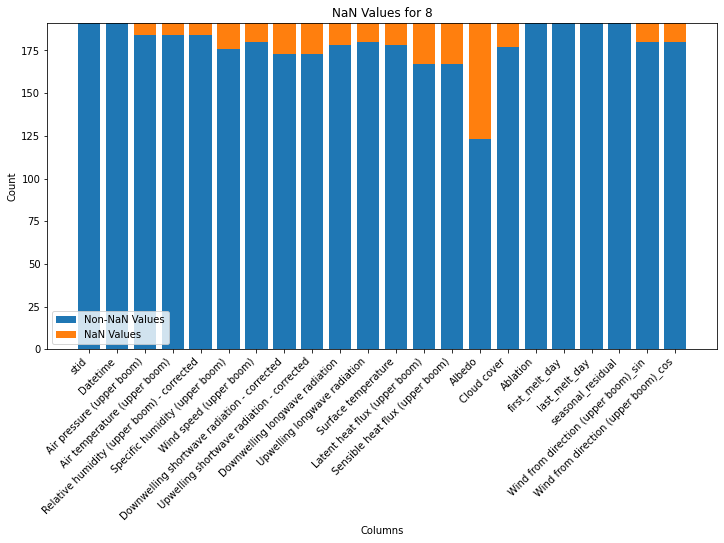

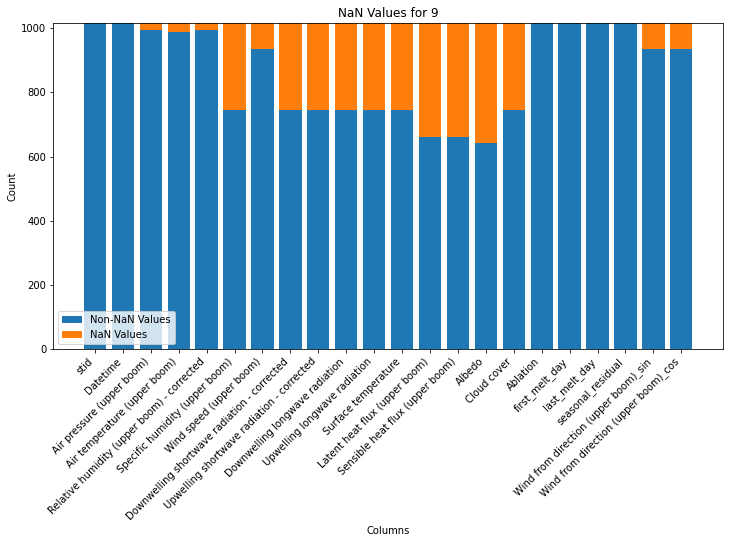

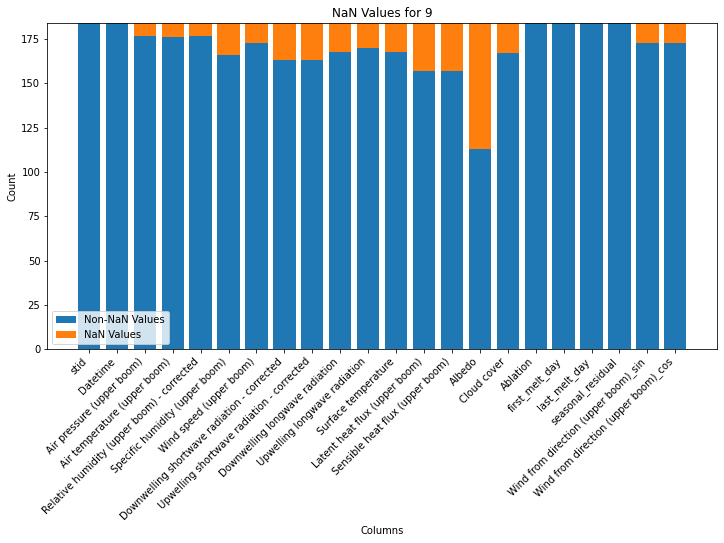

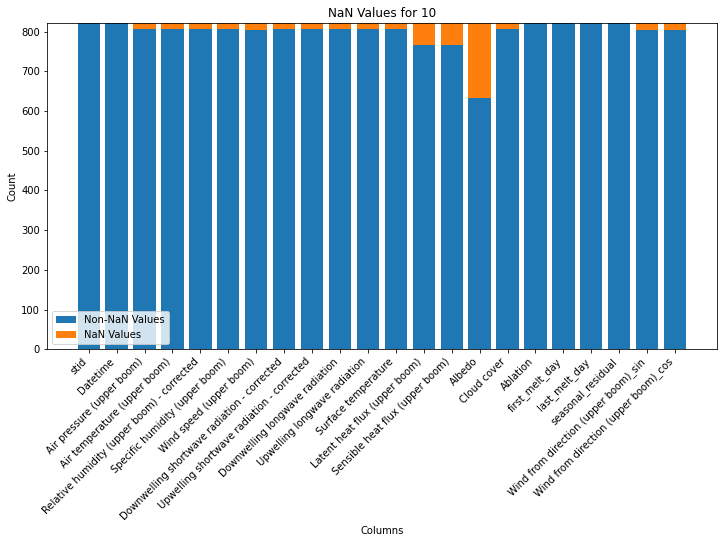

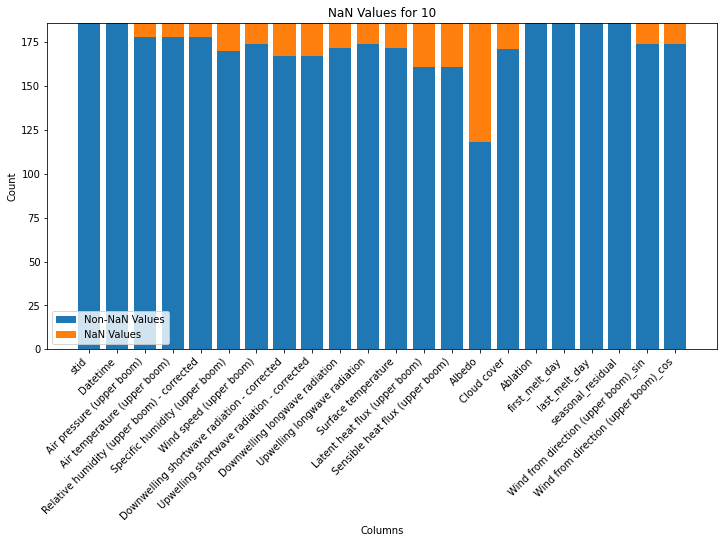

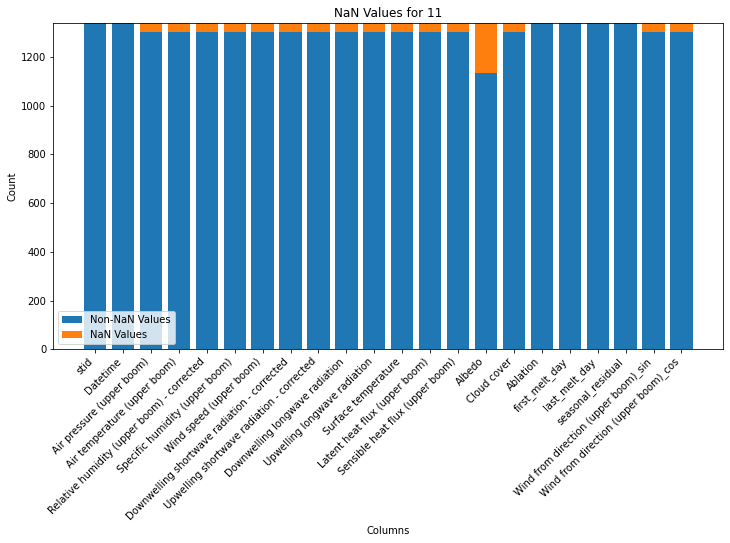

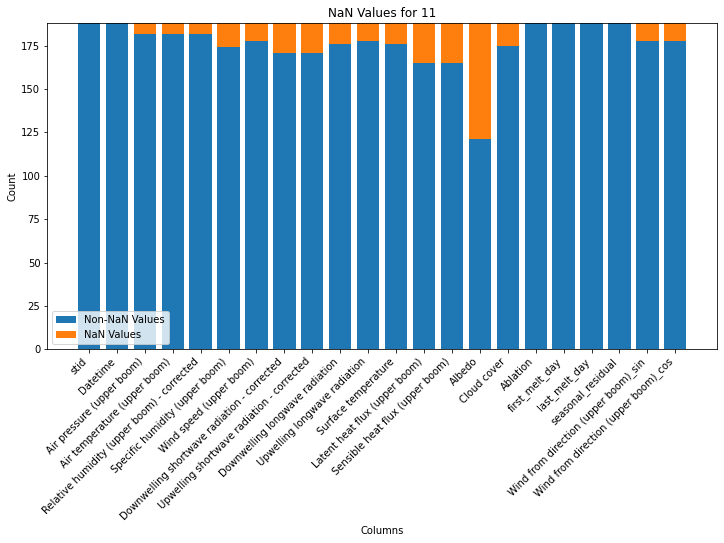

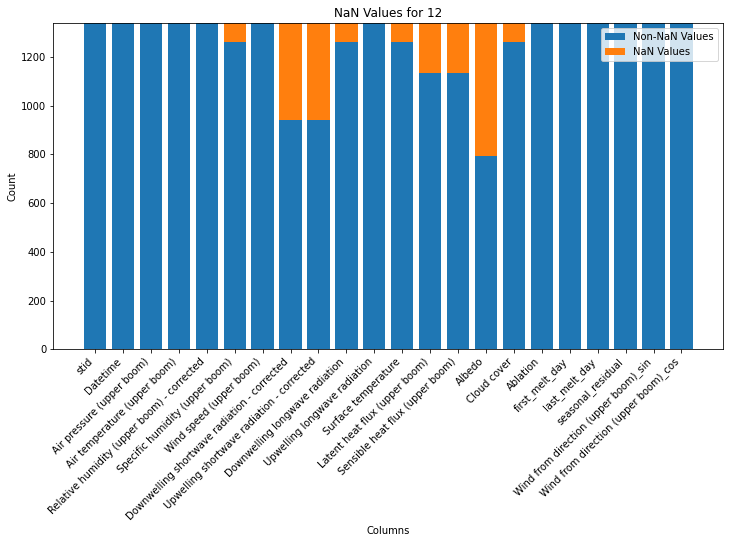

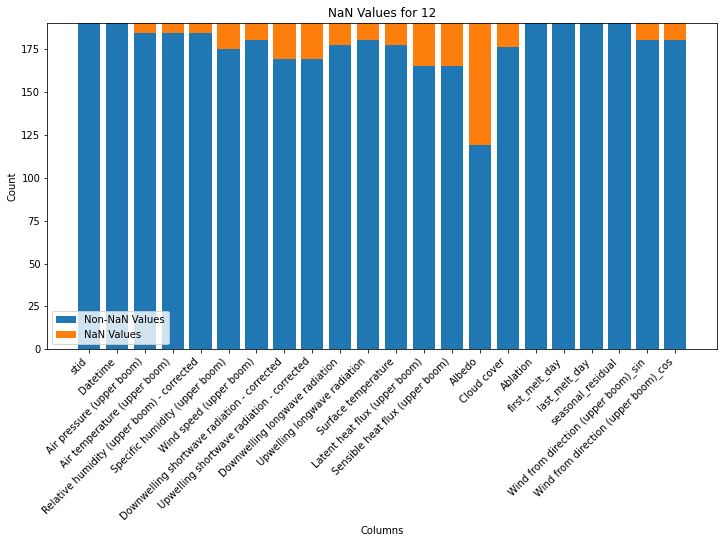

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    ablation_df = station_df[station_df['Ablation'] == True]
    
    # Plot 1: Bar plot with total count of observations and NaN values as stacked bars
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    nan_counts = station_df.isna().sum()
    non_nan_counts = station_df.notna().sum()
    
    ax1.bar(nan_counts.index, non_nan_counts, label='Non-NaN Values')
    ax1.bar(nan_counts.index, nan_counts, bottom=non_nan_counts, label='NaN Values')
    
    ax1.set_title(f'NaN Values for {stid}')
    ax1.set_xlabel('Columns')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    station_df = df[(df['stid'] == stid) & (df['first_melt_day'] == True) | (df['last_melt_day'] == True)]
    ablation_df = station_df[station_df['Ablation'] == True]
    
    # Plot 1: Bar plot with total count of observations and NaN values as stacked bars
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    nan_counts = station_df.isna().sum()
    non_nan_counts = station_df.notna().sum()
    
    ax1.bar(nan_counts.index, non_nan_counts, label='Non-NaN Values')
    ax1.bar(nan_counts.index, nan_counts, bottom=non_nan_counts, label='NaN Values')
    
    ax1.set_title(f'NaN Values for {stid}')
    ax1.set_xlabel('Columns')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    plt.xticks(rotation=45, ha='right')
    plt.show()
    

In [32]:
# Initialize an empty DataFrame to store the results
nan_summary = pd.DataFrame(columns=['Non-NaN Values', 'NaN Values'])

# Create a multi-level index for the summary DataFrame
multi_index = pd.MultiIndex(levels=[[], [], []], codes=[[], [], []], names=['stid', 'descriptor', 'column'])
nan_summary.index = multi_index

for stid in df['stid'].unique():
    # For the entire dataset
    station_df = df[df['stid'] == stid]
    non_nan_counts = station_df.notna().sum()
    nan_counts = station_df.isna().sum()
    
    # Save the counts in the summary DataFrame
    for col in non_nan_counts.index:
        nan_summary.loc[(stid, 'total', col), 'Non-NaN Values'] = non_nan_counts[col]
        nan_summary.loc[(stid, 'total', col), 'NaN Values'] = nan_counts[col]
    
    # For the ablation period only
    station_df = df[((df['stid'] == stid) & (df['first_melt_day'] == True)) | (df['last_melt_day'] == True)]
    non_nan_counts = station_df.notna().sum()
    nan_counts = station_df.isna().sum()
    
    # Save the counts in the summary DataFrame
    for col in non_nan_counts.index:
        nan_summary.loc[(stid, 'Melt Onset Day/ Melt End Day', col), 'Non-NaN Values'] = non_nan_counts[col]
        nan_summary.loc[(stid, 'Melt Onset Day/ Melt End Day', col), 'NaN Values'] = nan_counts[col]



In [33]:
import textwrap

def format_dataframe(nan_summary):
    formatted_df = nan_summary.reset_index()
    formatted_df = formatted_df[formatted_df['descriptor'] == 'total'].drop(columns=['descriptor', 'Non-NaN Values'])

    all_training_count = sum(formatted_df['NaN Values'])
    melt_count = sum(formatted_df[formatted_df['column'].isin(['first_melt_day', 'last_melt_day'])]['NaN Values'])

    formatted_df['All Training Instances'] = formatted_df['NaN Values'].apply(lambda x: x)
    formatted_df['Melt Onset Day/ Melt End Day'] = formatted_df['NaN Values'].apply(lambda x: x)

    formatted_df = formatted_df.drop(columns=['NaN Values'])
    formatted_df.columns = ['stid', 'Column', 'All Training Instances', 'Melt Onset Day/ Melt End Day']
    formatted_df = formatted_df.set_index(['stid', 'Column'])
    formatted_df = formatted_df[(formatted_df['All Training Instances'] > 0) | (formatted_df['Melt Onset Day/ Melt End Day'] > 0)]
    return formatted_df

formatted_df = format_dataframe(nan_summary)
all_training_count = df['first_melt_day'].count()
melt_count = df[(df['first_melt_day'] == True) | (df['last_melt_day'] == True)]
melt_count = melt_count['first_melt_day'].count()

def create_latex_table(formatted_df, all_training_count, melt_count):
    latex_table = textwrap.dedent(fr"""
        \begin{{table}}[H]
        \label{{tab:: NaN values of SCO_L}}
        \centering
        \begin{{tabularx}}{{\linewidth}}{{
          |c
           |>{{\hsize=4\hsize}}c
          |>{{\hsize=8\hsize}}c
          |>{{\hsize=4\hsize}}c|
        }}
        \toprule
         & \thead{{\textbf{{Total Training ({all_training_count})}}}} & \thead{{\textbf{{Melt Onset \& Melt End Day ({melt_count})}}}} \\
        \midrule
        & NaN  values & NaN  values \\
        \midrule
    """)

    for index, row in formatted_df.iterrows():
        latex_table += f"{index[1]} & {row['All Training Instances']} & {row['Melt Onset Day/ Melt End Day']} \\\\\n"

    latex_table += r"""
        \end{tabularx}
        \caption{NaN values of SCO_L}
        \end{table}
    """

    return latex_table

print(create_latex_table(formatted_df, all_training_count, melt_count))



\begin{table}[H]
\label{tab:: NaN values of SCO_L}
\centering
\begin{tabularx}{\linewidth}{
  |c
   |>{\hsize=4\hsize}c
  |>{\hsize=8\hsize}c
  |>{\hsize=4\hsize}c|
}
\toprule
 & \thead{\textbf{Total Training (19809)}} & \thead{\textbf{Melt Onset \& Melt End Day (352)}} \\
\midrule
& NaN  values & NaN  values \\
\midrule
Air pressure (upper boom) & 1 & 1 \\
Air temperature (upper boom) & 1 & 1 \\
Relative humidity (upper boom) - corrected & 1 & 1 \\
Specific humidity (upper boom) & 1 & 1 \\
Wind speed (upper boom) & 1 & 1 \\
Downwelling shortwave radiation - corrected & 1 & 1 \\
Upwelling shortwave radiation - corrected & 1 & 1 \\
Downwelling longwave radiation & 1 & 1 \\
Upwelling longwave radiation & 1 & 1 \\
Surface temperature & 1 & 1 \\
Latent heat flux (upper boom) & 6 & 6 \\
Sensible heat flux (upper boom) & 6 & 6 \\
Albedo & 55 & 55 \\
Cloud cover & 1 & 1 \\
Wind from direction (upper boom)_sin & 1 & 1 \\
Wind from direction (upper boom)_cos & 1 & 1 \\
Air pressure (upper boom

In [34]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'ID',
                'Wind from direction (upper boom)',
                'Ablation',
                'Melting Season', # We drop melting season later 
                'month',
                'month_sin',
                'month_cos',
                'day', 
                'day_sin',
                'day_cos',
                'hour', 
                'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods',
                'Year',
                'first_melt_day',
                'last_melt_day',
                'DayOfYear',
                'Datetime',
                #'seasonal_residual'
               ]



df = df[[column for column in df.columns if column not in exclude_list]]
data = df.copy()

In [35]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['stid', 
              'Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual',
              'residual_smoothed',
              'Datetime',
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])
data[num_cols] = scaler.fit_transform(data[num_cols])

df['seasonal_residual'] = scaler.fit_transform(df['seasonal_residual'].values.reshape(-1, 1))
data['seasonal_residual'] = scaler.fit_transform(data['seasonal_residual'].values.reshape(-1, 1))

In [36]:
## This bit only for baseline models
df_base = df
print(df_base['Albedo'].isna().sum())
df_base['Albedo'] = df_base['Albedo'].fillna(method='bfill')
print(df_base.isna().sum())
df_base = df_base.dropna()

from sklearn.model_selection import train_test_split

# Get unique stid values
stid_values = df_base['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df_base = df_base[df_base['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df_base.drop([y], axis=1), subset_df_base[y], test_size=0.3, random_state=123, shuffle =True)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train_base = pd.concat(X_train)
X_test_base = pd.concat(X_test)
y_train_base = pd.concat(y_train)
y_test_base = pd.concat(y_test)

3052
stid                                              0
Air pressure (upper boom)                       293
Air temperature (upper boom)                    298
Relative humidity (upper boom) - corrected      430
Specific humidity (upper boom)                 1273
Wind speed (upper boom)                        1155
Downwelling shortwave radiation - corrected    1643
Upwelling shortwave radiation - corrected      1643
Downwelling longwave radiation                 1039
Upwelling longwave radiation                    991
Surface temperature                            1071
Latent heat flux (upper boom)                  3222
Sensible heat flux (upper boom)                3222
Albedo                                           25
Cloud cover                                    1071
seasonal_residual                                 0
Wind from direction (upper boom)_sin           1155
Wind from direction (upper boom)_cos           1155
dtype: int64


In [37]:
# Get unique stid values
stid_values = df['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df = df[df['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df.drop([y], axis=1), subset_df[y], test_size=0.3, random_state=123, shuffle =True)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

In [38]:
print(len(df))
print(len(X_train) * 0.7)
print(len(X_train) * 0.3)
print(len(X_test))

19809
9702.699999999999
4158.3
5948


In [39]:
print(len(df_base))
print(len(X_train_base) * 0.7)
print(len(X_train_base) * 0.3)
print(len(X_test_base))

16184
7926.799999999999
3397.2
4860


In [40]:
19809 - 16184 + 3052

6677

In [41]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

In [42]:
len(X_train_base)

11324

In [43]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + 0.5] * len(indices), c=indices, marker="_", lw=lw, cmap=plt.cm.coolwarm, vmin=-0.2, vmax=1.2)

    ax.set_xlabel("Sample index")
    ax.set_ylabel("CV iteration")
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.set_title("{}".format(type(cv).__name__))
    return ax

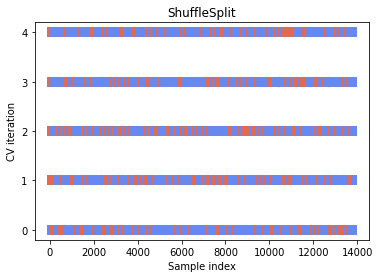

In [44]:
fig, ax = plt.subplots()
plot_cv_indices(cv, X_train, y_train, ax, cv.get_n_splits(X_train, y_train))
plt.show()

## Regression Modelling

-------

## Selected Models

In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # Required to enable HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import xgboost as xgb
from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [46]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, shuffle = True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [47]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, n_jobs=-1, log_scale=False):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(f"{param_name}")
    plt.ylabel("Score")
    plt.grid()

    if log_scale:
        plt.xscale("log")

    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best hyperparameters: {'fit_intercept': True}
Average R^2 test score from cv : 0.41024128272024674
Standard deviation of R^2 test scores from cv: 0.005326491147694093


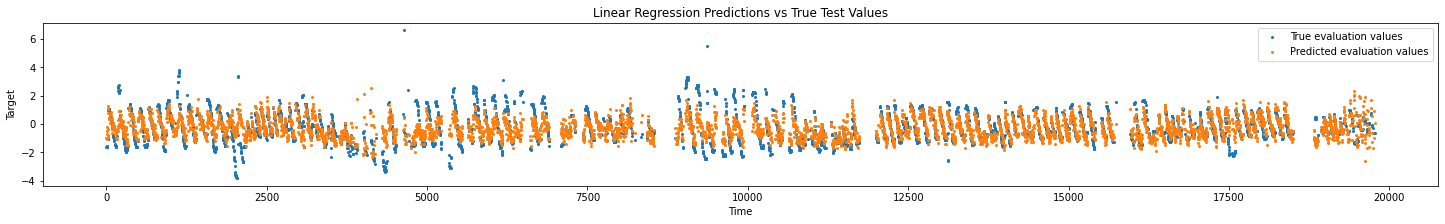

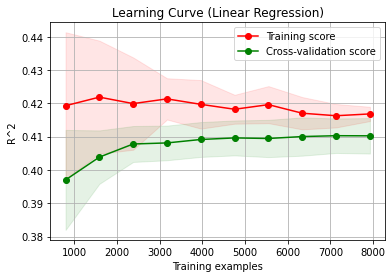

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.4103935024873545
MSE on validation set (seasonal_residual):  0.0029247711729666285
------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.37301153458436886
MSE on test set (seasonal_residual):  1.039476488460267


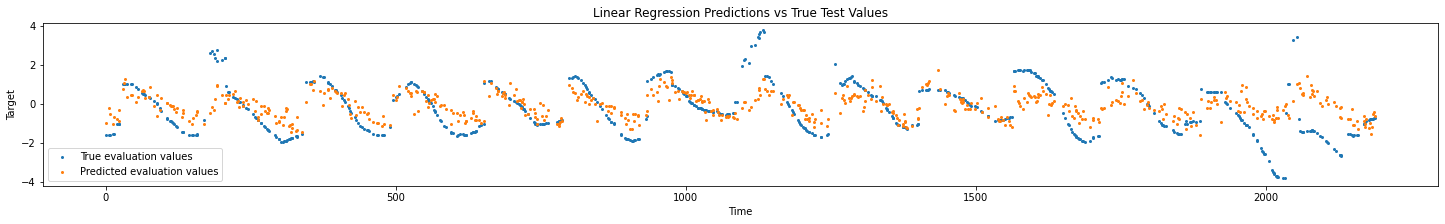

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.26781275533748705
MSE on test set (seasonal_residual):  0.421600512670224


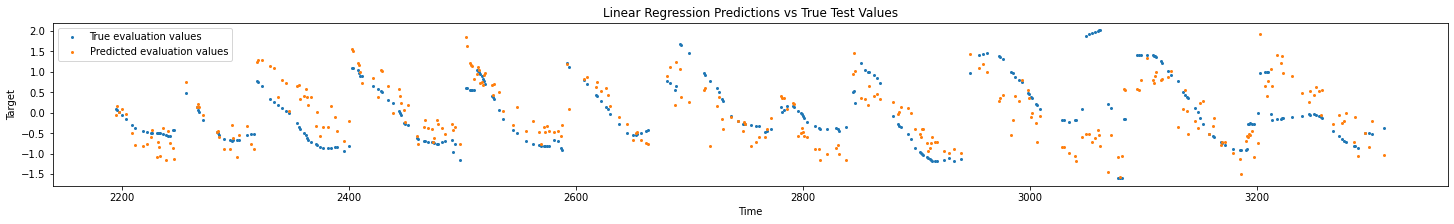

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.07481644952911215
MSE on test set (seasonal_residual):  1.209385114379475


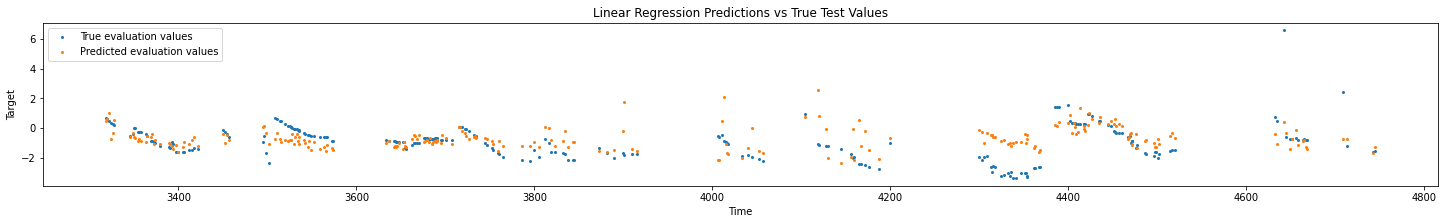

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.3499972771075074
MSE on test set (seasonal_residual):  1.14717016107473


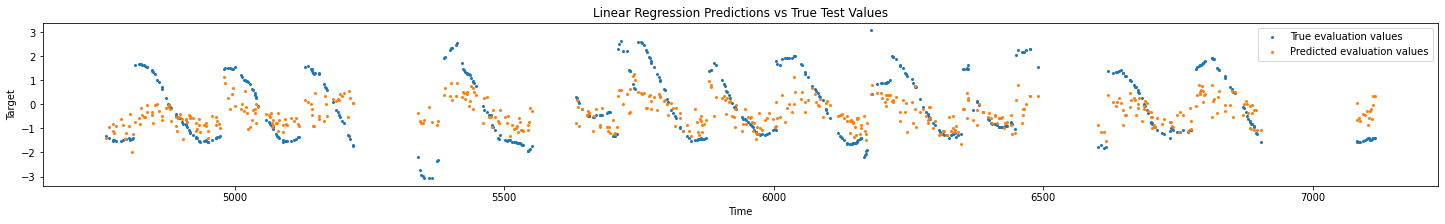

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.2785910955280596
MSE on test set (seasonal_residual):  0.2830485758754042


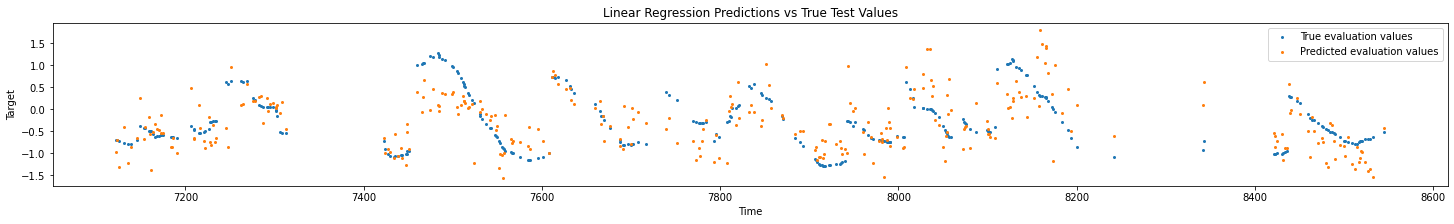

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.4663656973383823
MSE on test set (seasonal_residual):  1.5551611386322253


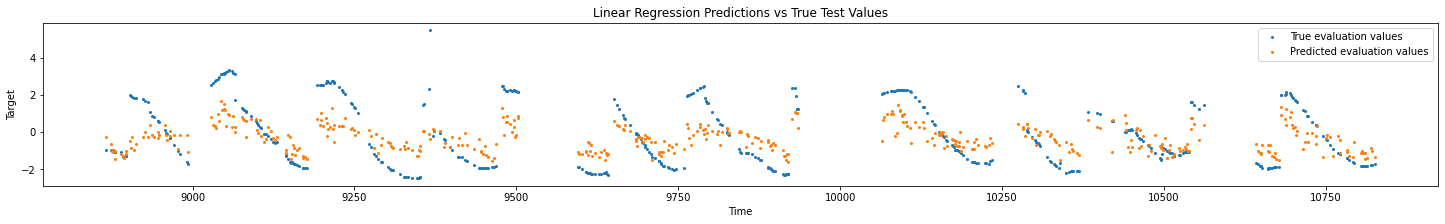

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  -0.2738732727596249
MSE on test set (seasonal_residual):  0.48003700895024254


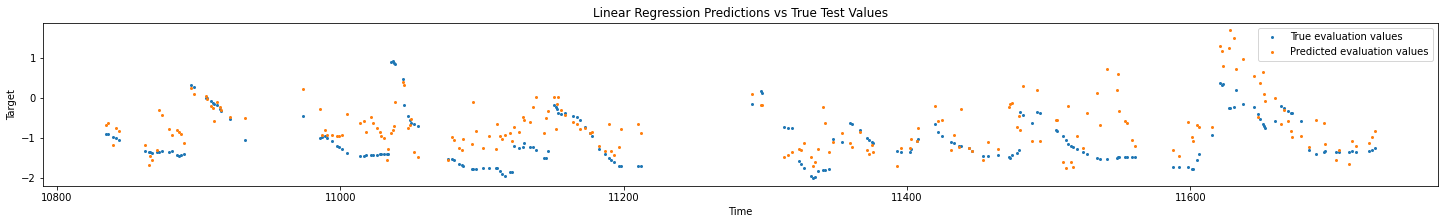

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.6546840143105167
MSE on test set (seasonal_residual):  0.30860390418896205


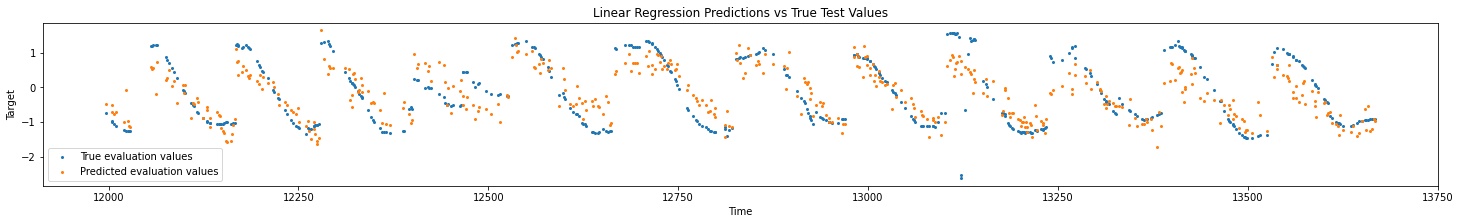

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.6136888837734045
MSE on test set (seasonal_residual):  0.18899645869808676


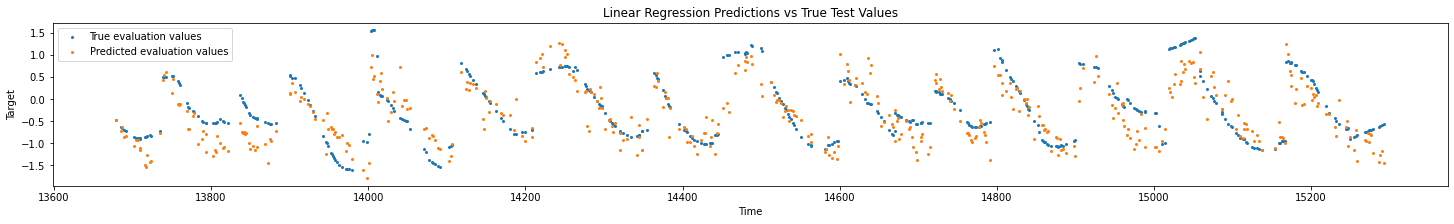

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.5701387478312263
MSE on test set (seasonal_residual):  0.45683034856065413


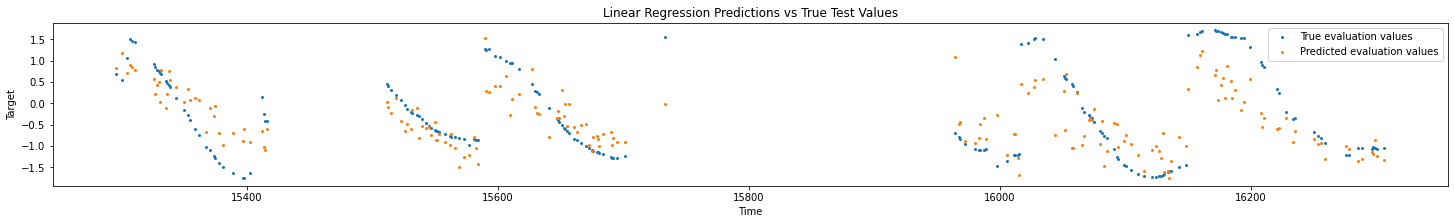

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.41047116901862557
MSE on test set (seasonal_residual):  0.22545179562645748


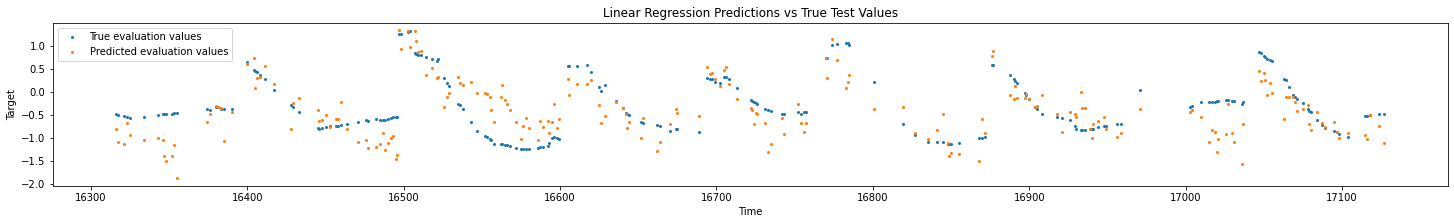

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.34791826260299696
MSE on test set (seasonal_residual):  0.4287699729823155


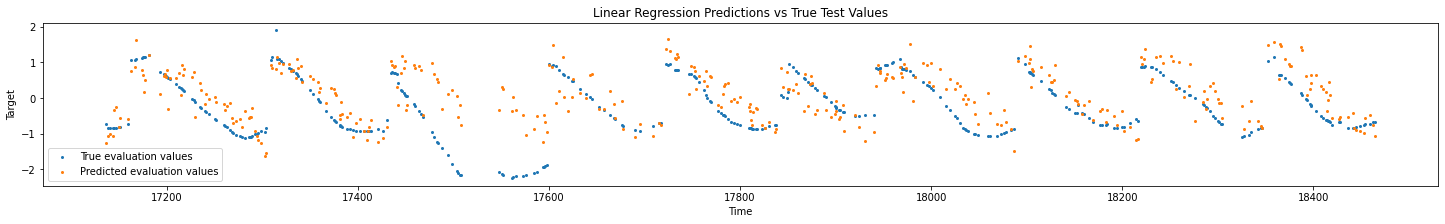

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  -1.2889203262096802
MSE on test set (seasonal_residual):  0.6407349744100349


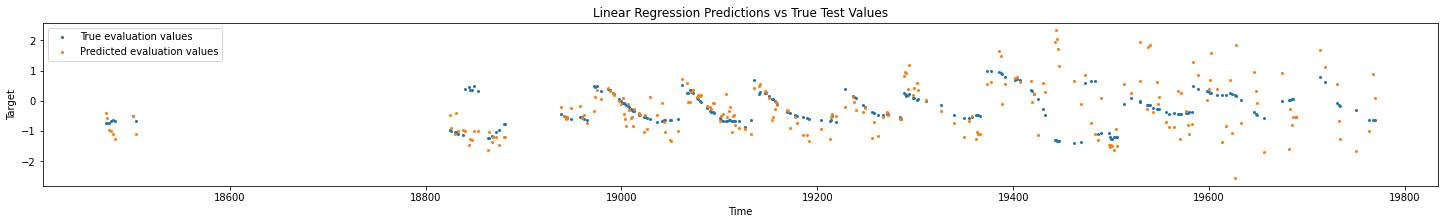

In [47]:
# Create the Linear Regression Model
lr_model = LinearRegression()

# Define hyperparameter search space
param_grid = {
    'fit_intercept': [True, False]
 #   'normalize': [True, False]
}

# Create grid search object
grid_search = GridSearchCV(lr_model, param_grid, cv=cv, n_jobs=-1, verbose=2)

# Fit the grid search object to the training data
grid_search.fit(X_train_base, y_train_base)

# Get the best estimator
best_lr_model = grid_search.best_estimator_
best_estimator = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_base = best_lr_model.predict(X_test_base)
r2 = r2_score(y_test_base, y_pred_base)
mse = mean_squared_error(y_test_base, y_pred_base, squared=True)

print("Best hyperparameters:", grid_search.best_params_)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])

y_pred_station = scaler.inverse_transform(y_pred_base.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test_base.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test_base.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test_base.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("Linear Regression Predictions vs True Test Values")
plt.legend()
plt.show()

plot_learning_curve(best_estimator, "Learning Curve (Linear Regression)", X_train_base, y_train_base, cv=cv)
plt.show()


print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train_base.loc[X_train_base['stid'] == value]
    X_test_station = X_test_base.loc[X_test_base['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train_base.loc[X_train_station.index]
    y_test_station = y_test_base.loc[X_test_station.index]

    y_pred_station = best_lr_model.predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))

    y_pred_train_station = best_lr_model.predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)

    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)

    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("Linear Regression Predictions vs True Test Values")
    plt.legend()
    plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_seasonal_residual:  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.8}
------------------------------------------------------------------------------------
Average R^2 test score from cv : 0.6230860214145487
Standard deviation of R^2 test scores from cv: 0.013509636511912367


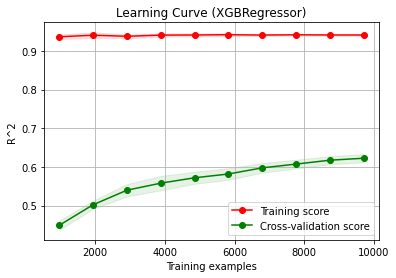

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.6434041147576495
MSE on validation set (seasonal_residual):  0.001888878887872394


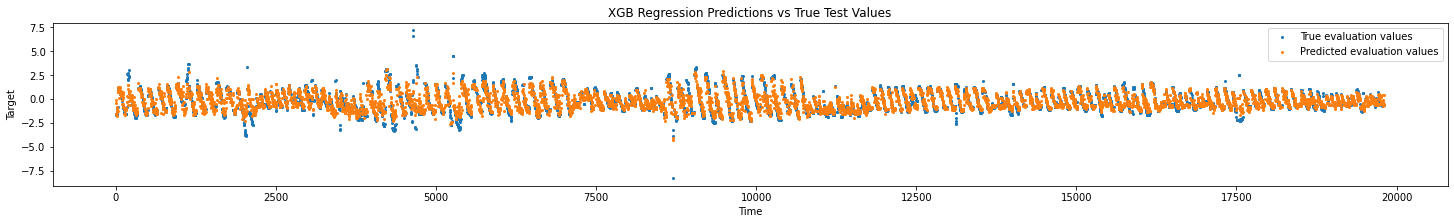

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.565723674030119
MSE on test set (seasonal_residual):  0.721217840264268


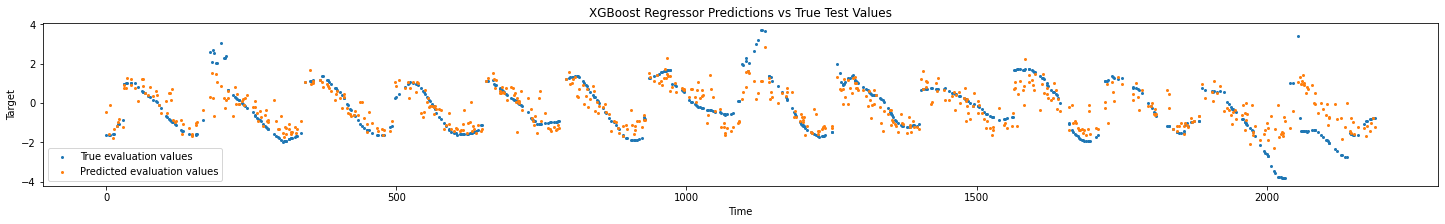

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.5236685707578439
MSE on test set (seasonal_residual):  0.24528477447078278


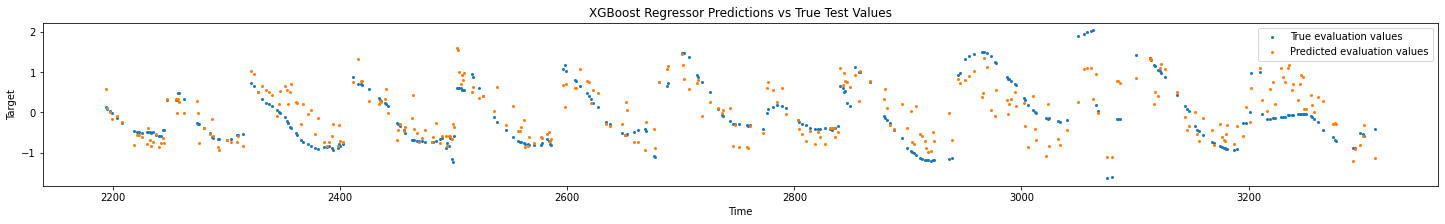

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.5076818646081125
MSE on test set (seasonal_residual):  1.0872809981928833


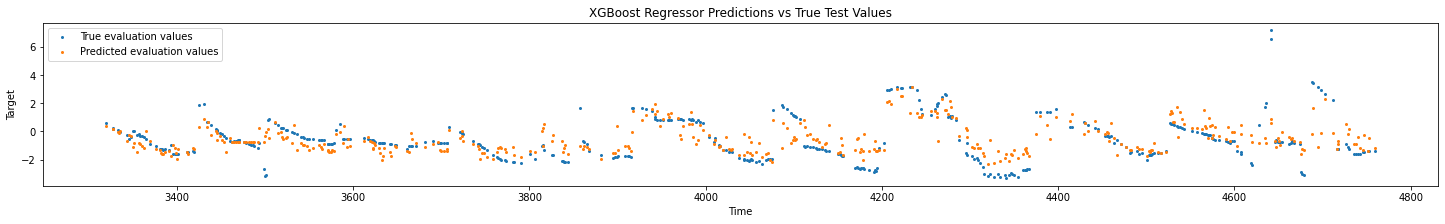

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.652902934333083
MSE on test set (seasonal_residual):  0.7383845915277906


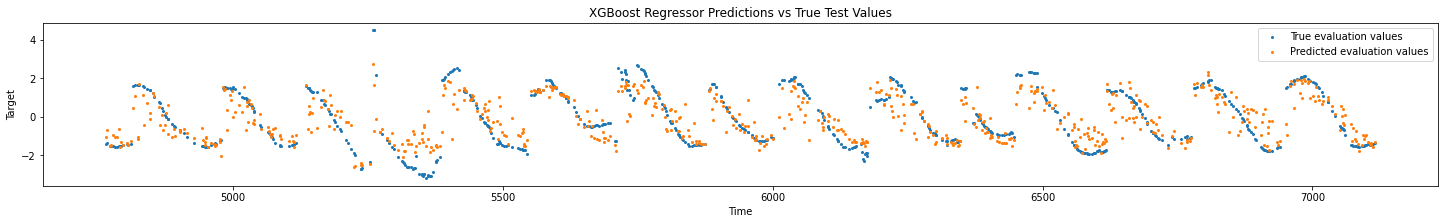

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.602678071688417
MSE on test set (seasonal_residual):  0.16311555978694753


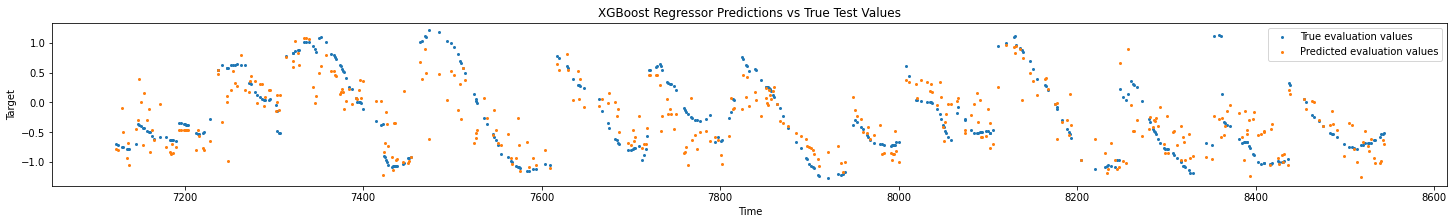

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.6872943119877359
MSE on test set (seasonal_residual):  0.7795734402123208


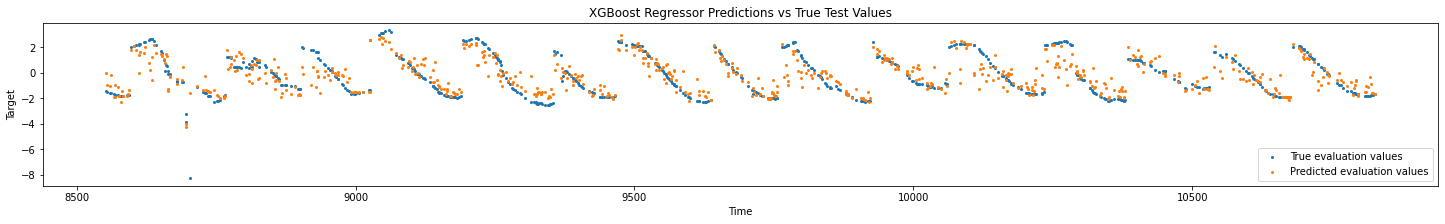

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  0.4982584863777221
MSE on test set (seasonal_residual):  0.15987471890186447


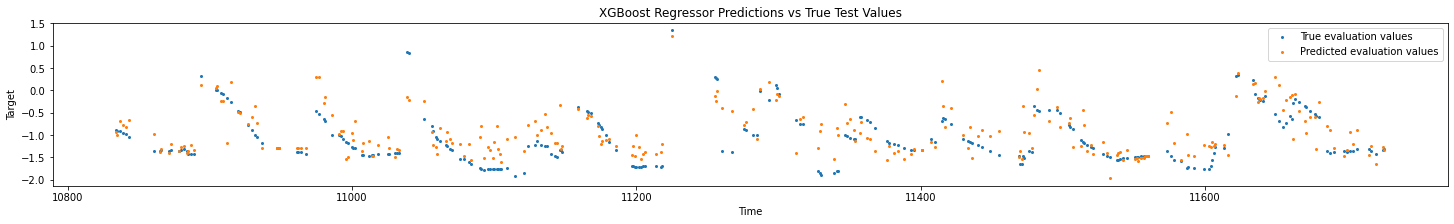

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.7244893714762203
MSE on test set (seasonal_residual):  0.23465873563698333


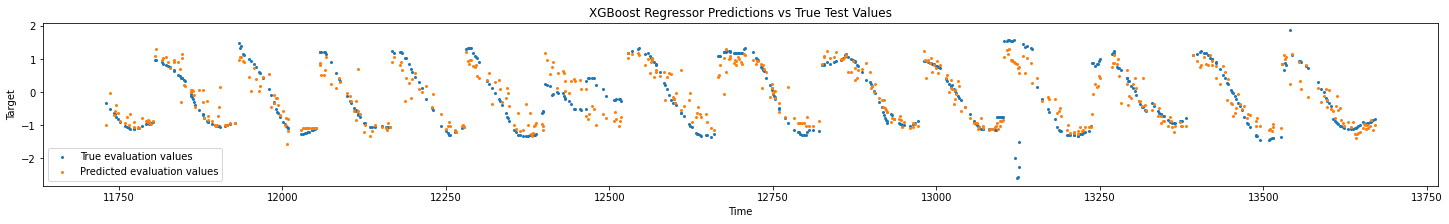

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.7726349410157373
MSE on test set (seasonal_residual):  0.11276064639633464


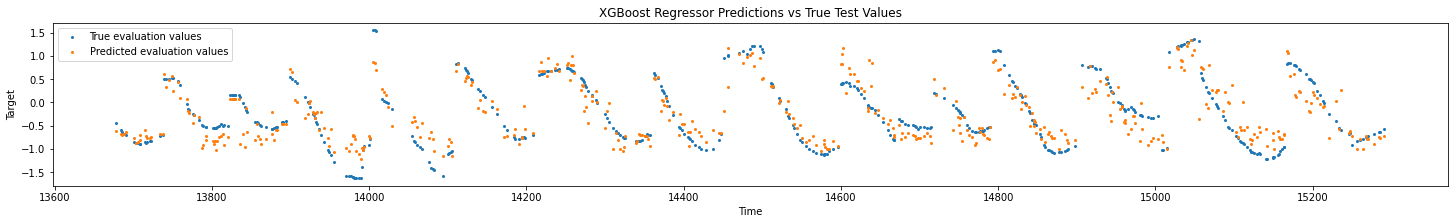

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.6807247540932208
MSE on test set (seasonal_residual):  0.3382537305282388


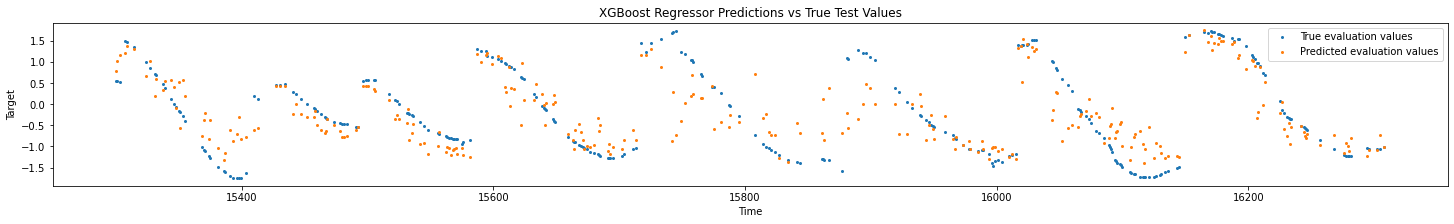

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.6067612239876985
MSE on test set (seasonal_residual):  0.13805215490823713


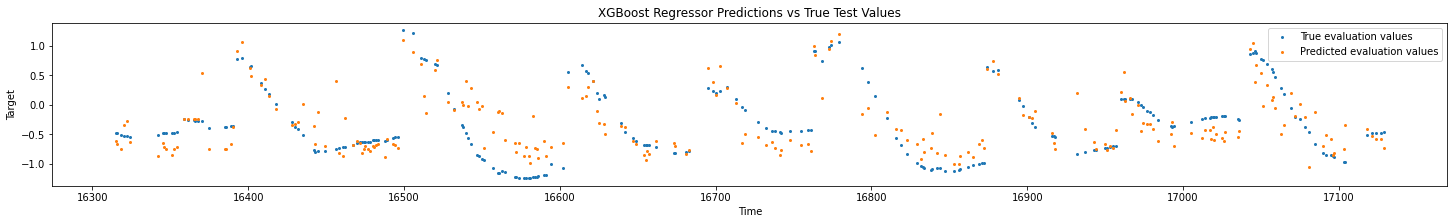

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.6511146069113007
MSE on test set (seasonal_residual):  0.2641405375517695


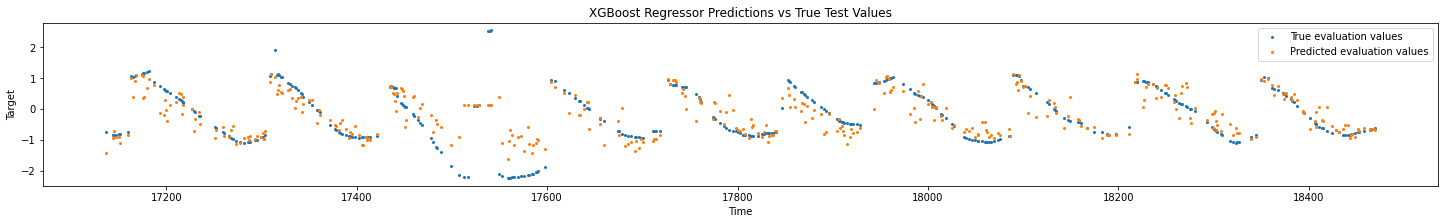

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  0.4989336898186204
MSE on test set (seasonal_residual):  0.1519942843120074


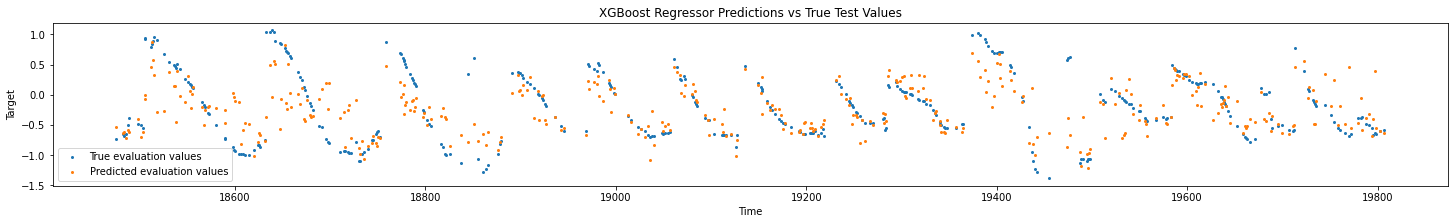

In [48]:
# XGB Regressor
model = xgb.XGBRegressor()

# Define the hyperparameter grid for tuning
param_grid ={
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 2, 4, 6, 8, 10], 
    'gamma': [0, 0.1, 0.5, 0.7, 1], 
    'subsample': [0.5, 0.7, 0.8, 0.9, 1], 
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

#Old params 

param_grid = {
'colsample_bytree': [1], 'gamma': [0], 'learning_rate': [0.05], 'max_depth': [15], 'min_child_weight': [10], 'subsample': [0.8]
}


# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"xgb_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"xgb_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=True)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_
param_name = 'learning_rate'
param_range = np.arange(0.01, 0.05, 0.1)
#plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
#plt.show()

plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

y_pred_station = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("XGB Regression Predictions vs True Test Values")
plt.legend()
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"xgb_model_{y}").predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = eval(f"xgb_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("XGBoost Regressor Predictions vs True Test Values")
    plt.legend()
    plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_seasonal_residual:  {'l2_regularization': 0, 'learning_rate': 0.05, 'max_depth': 15, 'max_iter': 500, 'min_samples_leaf': 10}
------------------------------------------------------------------------------------
Average R^2 test score from cv : 0.6183159971968634
Standard deviation of R^2 test scores from cv: 0.01187652767406436


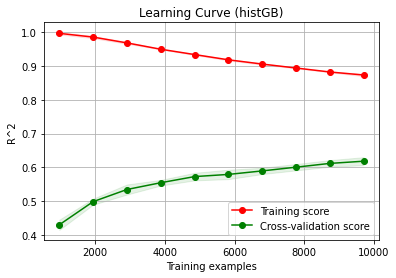

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.6257954925760143
MSE on validation set (seasonal_residual):  0.0019821512896579835


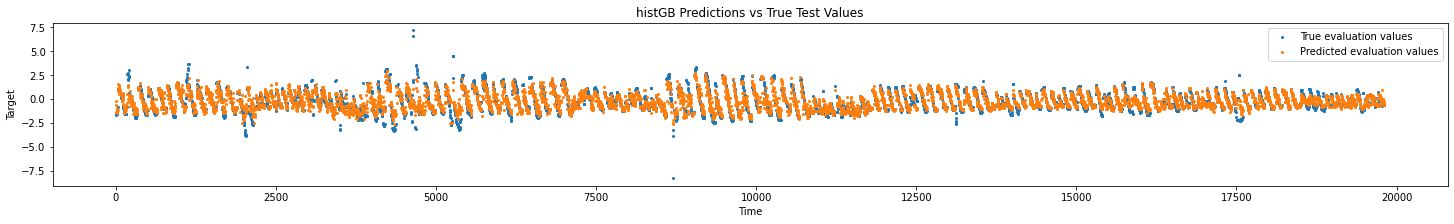

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.5458311938796974
MSE on test set (seasonal_residual):  0.7542539758158566


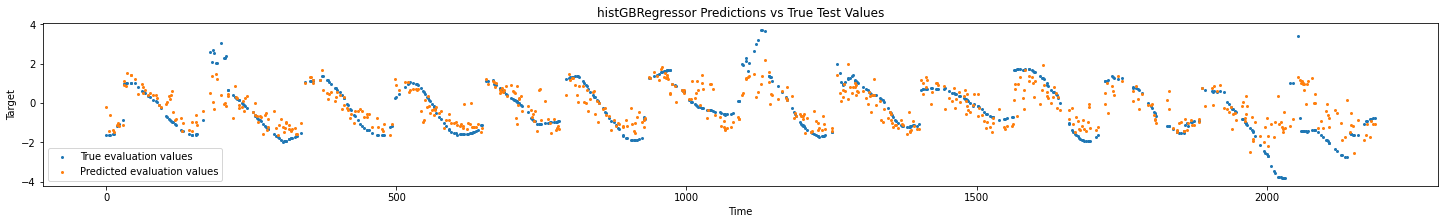

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.46219160544924076
MSE on test set (seasonal_residual):  0.2769420673663202


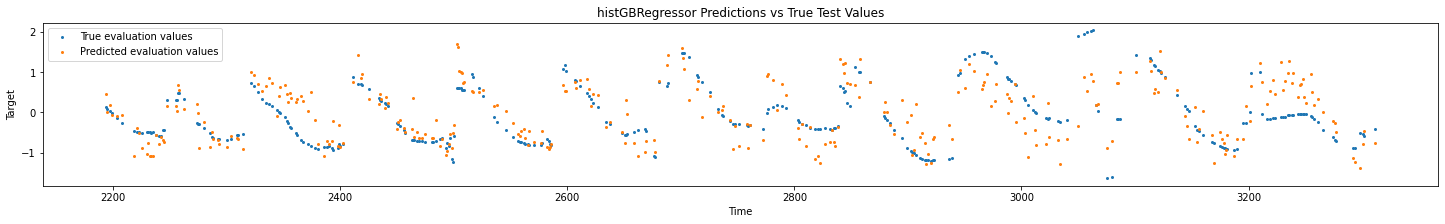

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.4889515169020693
MSE on test set (seasonal_residual):  1.1286468339935807


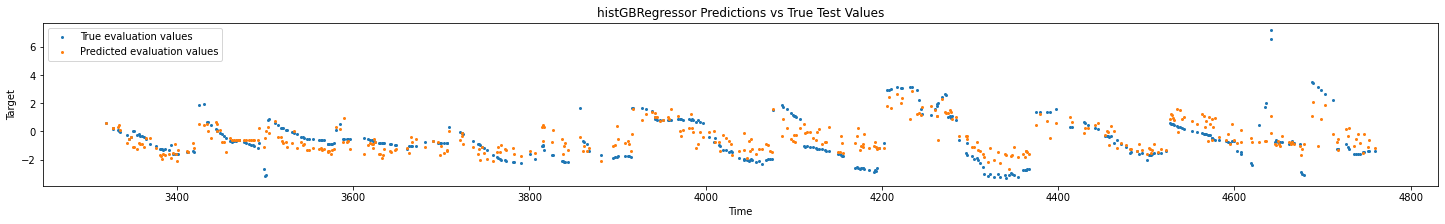

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.6427766820504457
MSE on test set (seasonal_residual):  0.7599263139882094


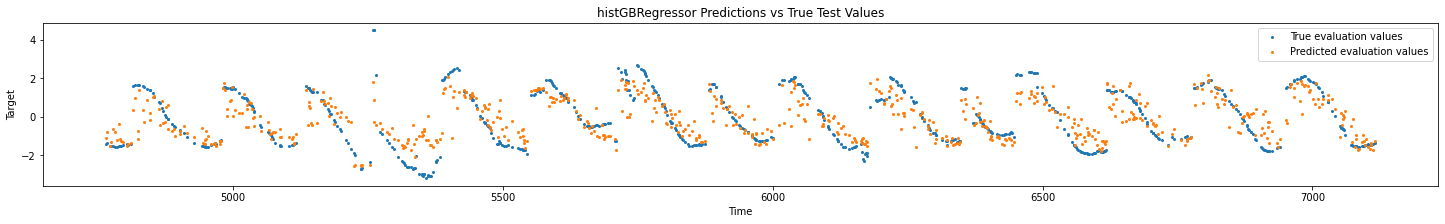

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.5329695449270336
MSE on test set (seasonal_residual):  0.19173352560858123


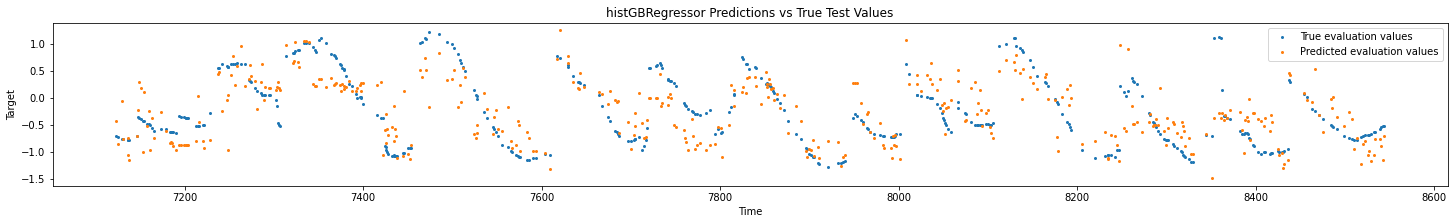

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.6871752444558902
MSE on test set (seasonal_residual):  0.779870274868603


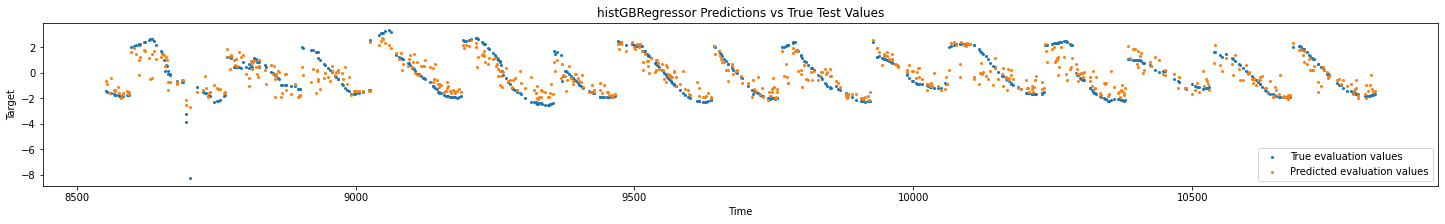

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  0.42029898016177847
MSE on test set (seasonal_residual):  0.18471570535327683


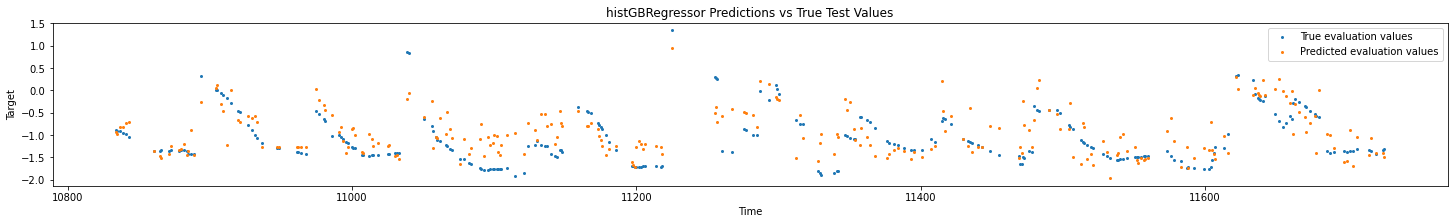

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.6894134977311359
MSE on test set (seasonal_residual):  0.26453366361521036


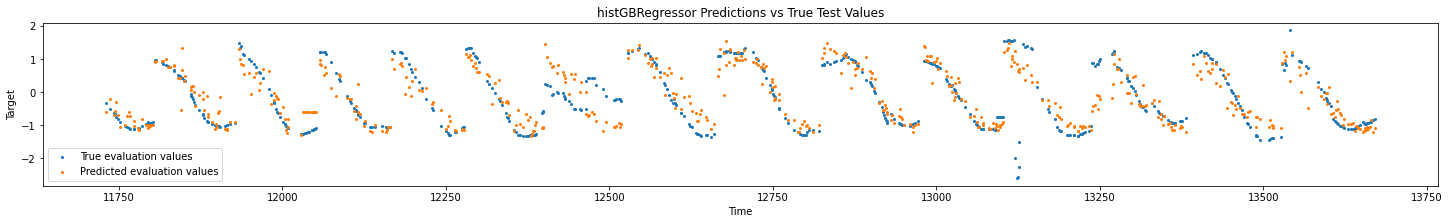

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.7416473564549184
MSE on test set (seasonal_residual):  0.1281287952268938


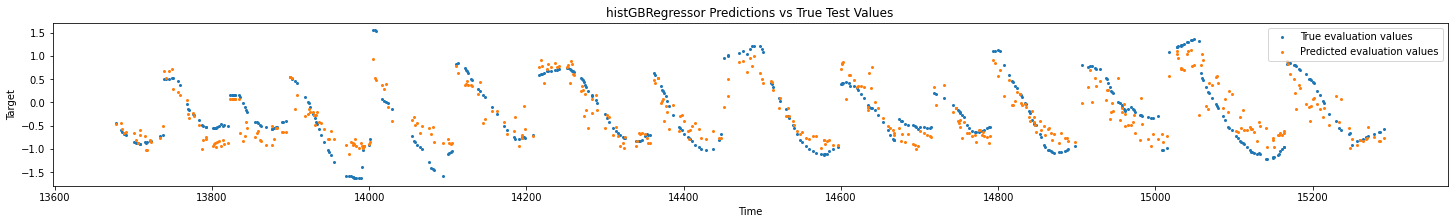

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.6711671009550392
MSE on test set (seasonal_residual):  0.34837951343979207


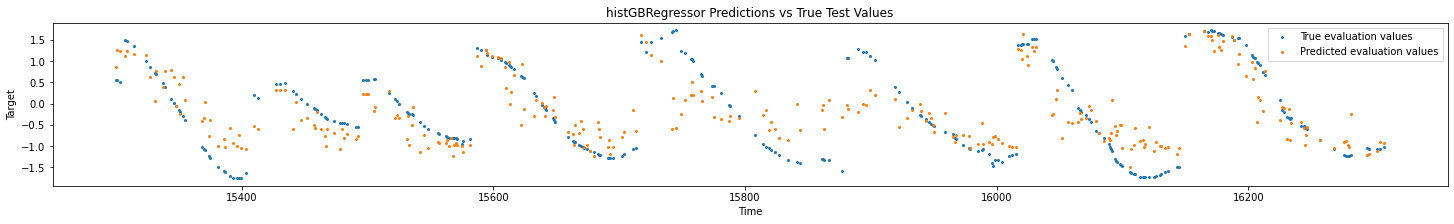

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.5879289019875888
MSE on test set (seasonal_residual):  0.1446635136872595


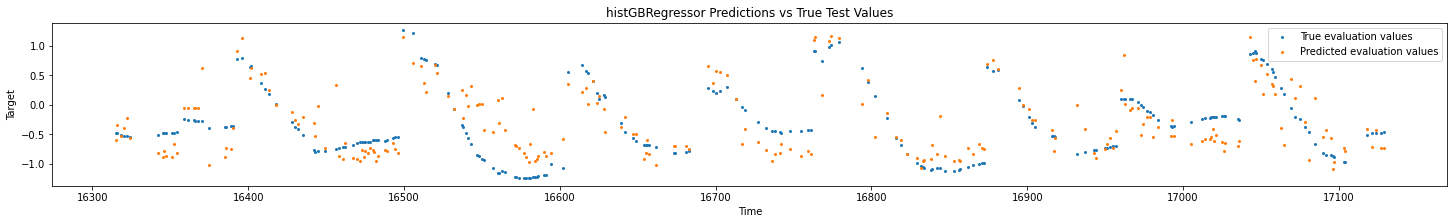

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.6275060675887163
MSE on test set (seasonal_residual):  0.28201452250789566


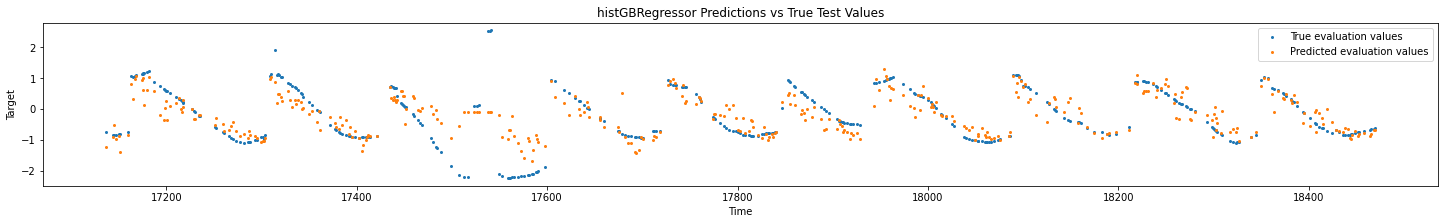

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  0.4050528329912514
MSE on test set (seasonal_residual):  0.18047225889167667


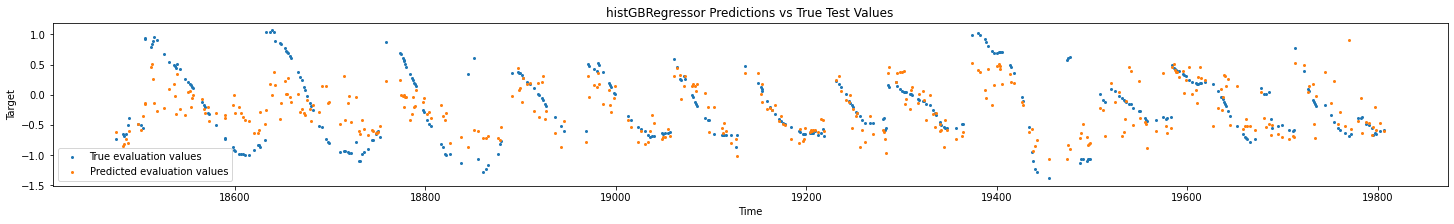

In [49]:
# This bit to find best HistGradientBoostingRegressor model for when Ablation == True and for both target variables
model = HistGradientBoostingRegressor()

# Define the hyperparameter grid for tuning
#hgb_params = {
#    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#    'max_iter': [100, 200, 300, 400, 500],
#    'max_depth': [5, 7, 9, 11, 13, 15],
#    'min_samples_leaf': [10, 20, 30, 50, 80, 100],
#    'max_leaf_nodes': [20, 31, 50, 70, 100, 150],
#    'l2_regularization': [0, 0.1, 0.5]
#}

#Old params

param_grid = {
    'max_depth': [15],#[3, 5, 7],
    'min_samples_leaf': [10],#[1, 3, 5],
 #   'max_samples_leaf': [150],
    'learning_rate': [0.05],#[0.1, 0.01, 0.001],
    'max_iter': [500],#[100, 500, 1000],
    'l2_regularization': [0],#[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"hist_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"hist_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=True)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_
param_name = 'learning_rate'
param_range = np.arange(0.01, 0.05, 0.1)
#plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
#plt.show()

plot_learning_curve(best_estimator, "Learning Curve (histGB)", X_train, y_train, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

y_pred_station = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("histGB Predictions vs True Test Values")
plt.legend()
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"hist_model_{y}").predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = eval(f"hist_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("histGBRegressor Predictions vs True Test Values")
    plt.legend()
    plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


# Create the k-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

# Define hyperparameter search space
param_grid = {
    'n_neighbors': [7], #range(1, 11),
    'weights':['distance'], # ['uniform', 'distance'],
    'metric': ['manhattan']#['euclidean', 'manhattan', 'minkowski']
}

# Create grid search object
grid_search = GridSearchCV(knn_model, param_grid, cv=cv, n_jobs=-1, verbose = 2) #, scoring='neg_mean_squared_error'

# Fit the grid search object to the training data
grid_search.fit(X_train_base, y_train_base)

# Get the best estimator
best_knn_model = grid_search.best_estimator_
best_estimator = grid_search.best_estimator_


# Evaluate the best model on the test set
y_pred_base = best_knn_model.predict(X_test_base)
r2 = r2_score(y_test_base, y_pred_base)
mse = mean_squared_error(y_test_base, y_pred_base, squared=True)

print("Best hyperparameters:", grid_search.best_params_)

print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])

plot_learning_curve(best_estimator, "Learning Curve (KNN Regressor)", X_train_base, y_train_base, cv=cv)
plt.show()

#print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
#print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
#mean_test_score = grid_search.cv_results_["mean_test_score"][0]
#std_test_score = grid_search.cv_results_["std_test_score"][0]

#best_estimator = grid_search.best_estimator_
#param_name = 'learning_rate'
#param_range = np.arange(0.01, 0.05, 0.1)
#plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
#plt.show()

#plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)
#plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

y_pred_station = scaler.inverse_transform(y_pred_base.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test_base.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test_base.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test_base.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("KNN Regression Predictions vs True Test Values")
plt.legend()
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train_base.loc[X_train_base['stid'] == value]
    X_test_station = X_test_base.loc[X_test_base['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train_base.loc[X_train_station.index]
    y_test_station = y_test_base.loc[X_test_station.index]

    y_pred_station = best_knn_model.predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = best_knn_model.predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("histGBRegressor Predictions vs True Test Values")
    plt.legend()
    plt.show()


------

In [ ]:
#filter = pd.concat([pd.Series(indices_first_melt_day), pd.Series(indices_last_melt_day)])
filter = expanded_indices_first + expanded_indices_last

# Evaluate the best model on the test set
y_pred =  xgb_model_seasonal_residual.predict(X_test.iloc[X_test.index.isin(filter)]) #eval(f"xgb_model_{y}").predict(X_test.iloc[filter])
y_test_filter = y_test.iloc[y_test.index.isin(filter)]

r2 = r2_score(y_test_filter, y_pred)
mse = mean_squared_error(y_test_filter, y_pred, squared=True)

print(f"R^2 score on validation set (filtred): ", r2)
print(f"MSE on validation set (filtred): ", mse)
print(f"Count of filtred values: ", len(y_test_filter))
print("------------------------------------------------------------------------------")

plt.figure(figsize=(15,10))
plt.subplot(4,1,4)
plt.title("Prediction")
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
plt.scatter(y_test_filter.index, y_test_filter.iloc[y_test_filter.index.isin(filter)], label="True evaluation values", alpha=1, s=4)
plt.scatter(y_test_filter.index, y_pred, label="Predicted evaluation values", alpha=1, s=4)
plt.xlabel('Time')
plt.ylabel('Seasonal output variable')
plt.legend()
plt.show()
    
for value, station_name in enumerate(station_names):
    print(station_name)

    plt.figure(figsize=(15,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = xgb_model_seasonal_residual.predict(X_test_station.iloc[X_test_station.index.isin(filter)])#eval(f"xgb_model_{y}").predict(X_test_station.iloc[filter])
    #y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    
    y_test_filter_station = y_test_station.iloc[y_test_station.index.isin(filter)]
    #y_test_filter_station = scaler.inverse_transform(y_test_filter_station.values.reshape(-1, 1))#.values.reshape(-1, 1))
    
    r2_station = r2_score(y_test_filter_station, y_pred_station)
    mse_station = mean_squared_error(y_test_filter_station, y_pred_station, squared=True)
    
    print(f"R^2 score on validation set (filtred): ", r2_station)
    print(f"RMSE on validation set (filtred): ", mse_station)
    print(f"Count of filtred values: ", len(y_test_filter_station))

    # Plot the seasonal output variable, trained values, tested values, and predicted values
  #  plt.scatter(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    plt.scatter(y_test_filter_station.index, y_test_station.iloc[y_test_station.index.isin(filter)], label="True evaluation values", alpha=1, s=4)
    plt.scatter(y_test_filter_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
    
 #   plt.scatter(y_test_filter_station.index, y_test_station.iloc[y_test_station.index.isin(filter)], label='True values',  linewidth=0.5)
 #   plt.scatter(y_test_filter_station.index, y_pred_station, label= 'Predicted values',linewidth=0.4)


    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()

## Filter by Melting Season and get feature importances 

In [49]:
import shap

explainer = eval(f"shap.Explainer(xgb_model_{y})")

In [50]:
X_set = pd.concat([X_train, X_test])
y_set = pd.concat([y_train, y_test])

positive_color = "#ca0020"
negative_color = "#92c5de"

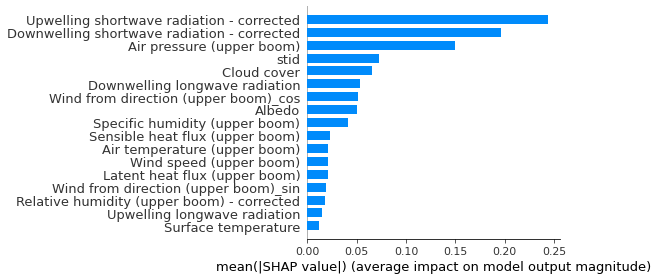

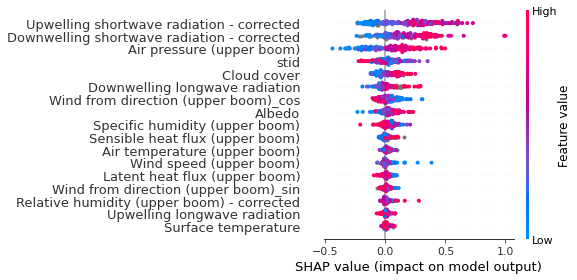

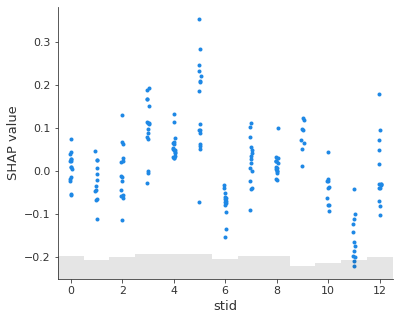

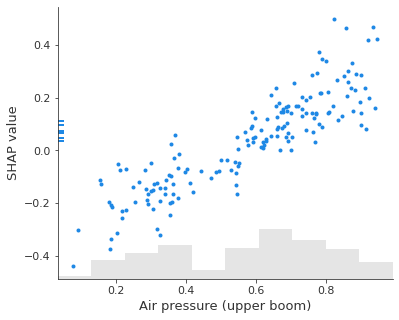

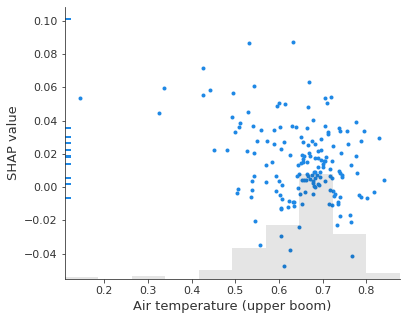

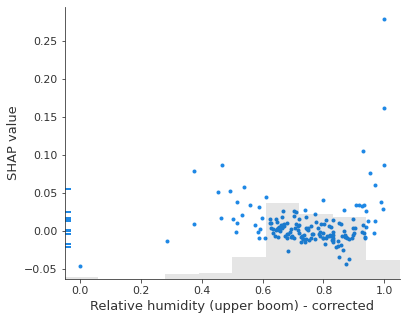

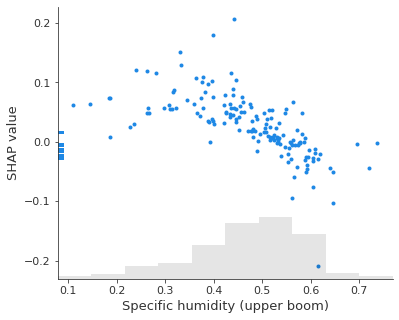

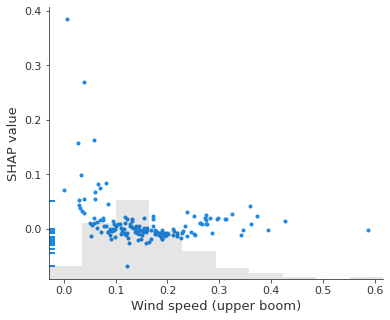

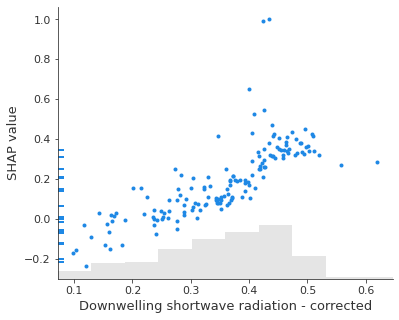

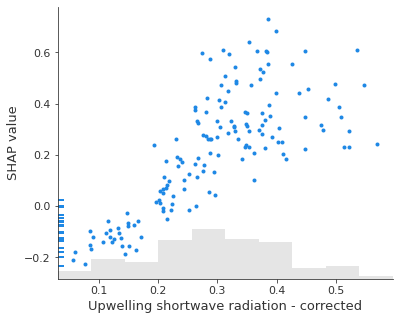

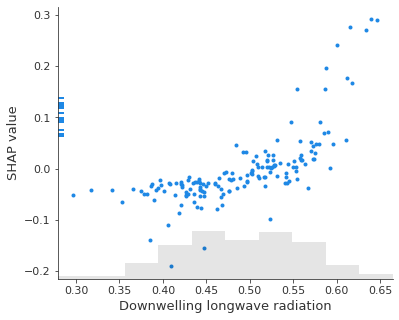

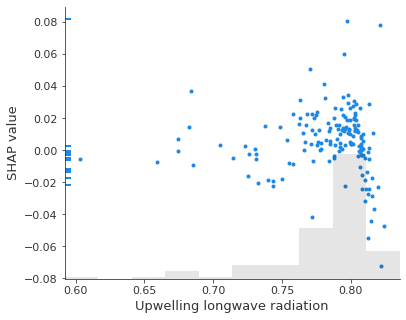

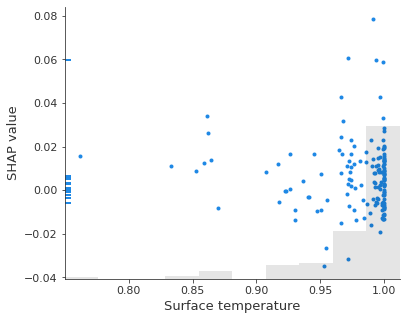

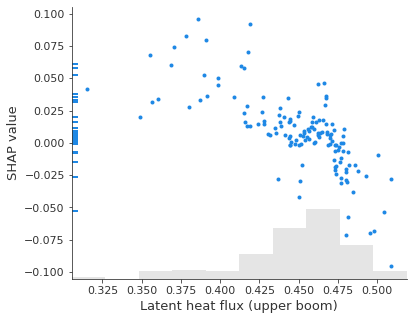

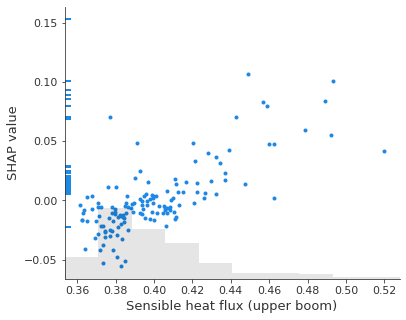

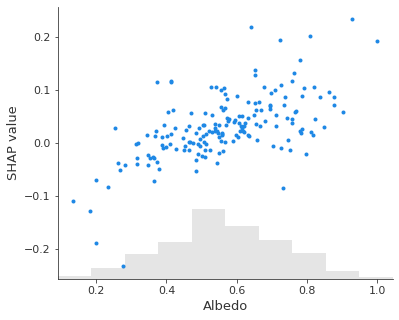

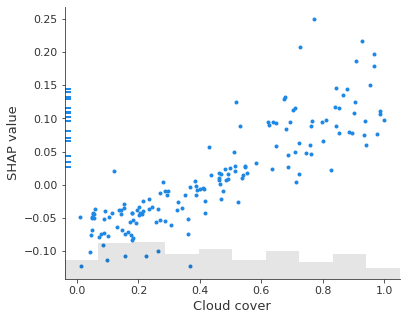

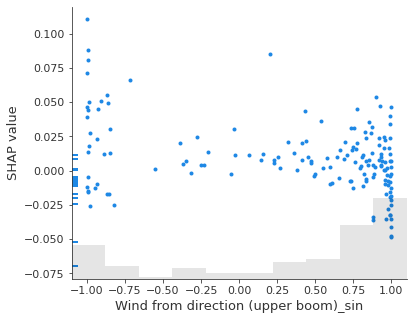

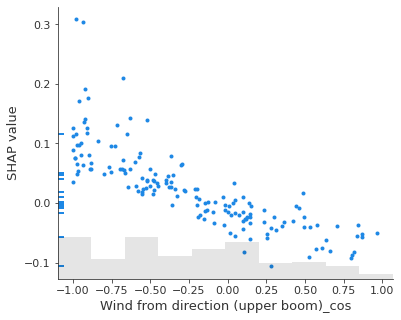

In [52]:
#filter = indices_middle.to_list()
#filter = indices_last_melt_day.to_list()
#filter = expanded_indices_last
filter = indices_first_melt_day.to_list()
#filter = expanded_indices_first

shap_values = explainer(X_set.loc[filter])
mean_abs_shap_values = shap_values.abs.mean(0)

X = X_set.loc[filter]
max_abs_shap_value = np.max(np.abs(shap_values.values))
shap_values = shap_values.values / max_abs_shap_value

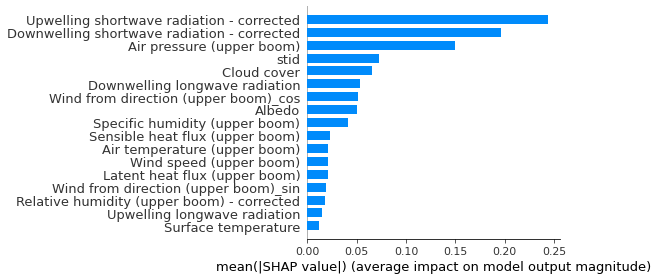

In [67]:
shap.summary_plot(shap_values, X, plot_type='bar', plot_size = (8,4))
# save as '{filter}_bar'

Top 5 Shapley values for the beginning of melting seasons


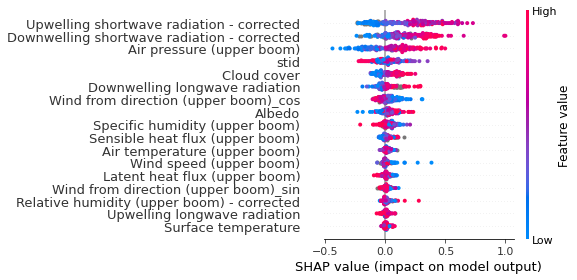

In [68]:
shap.summary_plot(shap_values, X, plot_type="dot", plot_size = (8,4))
# save as '{filter}_Dot'

In [56]:
for i in range(17):
    # Create a new Explanation object with the desired feature's SHAP values
    single_feature_shap_values = shap.Explanation(
        shap_values[:, i].reshape(-1, 1),
        explainer.expected_value,
        X_set.loc[filter].values[:, i].reshape(-1, 1),
        feature_names=[X_set.columns[i]]
    )
    shap.plots.scatter(single_feature_shap_values, color=single_feature_shap_values)
    
    #save as '{filter}_Scatter_{i}'

TypeError: scatter() got an unexpected keyword argument 'plot_cmap'

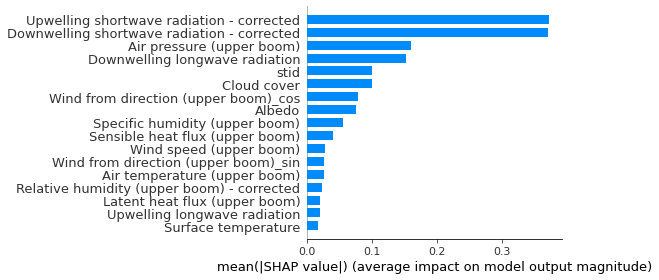

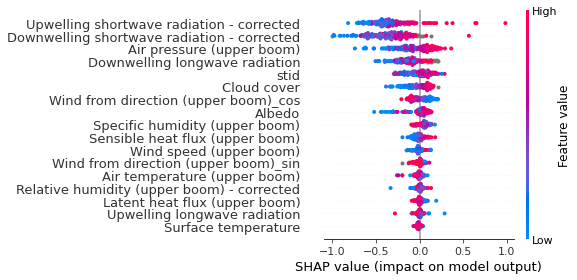

In [58]:
import os
import shap
import matplotlib.pyplot as plt

#filter = indices_middle.to_list()
filter = indices_last_melt_day.to_list()
#filter = expanded_indices_last
#filter = indices_first_melt_day.to_list()
#filter = expanded_indices_first

name = "melt-end-day"

shap_values = explainer(X_set.loc[filter])
mean_abs_shap_values = shap_values.abs.mean(0)

X = X_set.loc[filter]
max_abs_shap_value = np.max(np.abs(shap_values.values))
shap_values = shap_values.values / max_abs_shap_value

# Save the bar plot
plt.figure()
shap.summary_plot(shap_values, X, plot_type='bar', plot_size=(8, 4))

fig = plt.gcf()
#plt.savefig(os.path.expanduser('~/Desktop/{}_bar.png'.format(name)))
plt.close(fig)

# Save the dot plot
plt.figure()
shap.summary_plot(shap_values, X, plot_type="dot", plot_size=(8, 4))
fig = plt.gcf()
#plt.savefig(os.path.expanduser('~/Desktop/{}_dot.png'.format(name)))
plt.close(fig)

for i in range(17):
    # Create a new Explanation object with the desired feature's SHAP values
    single_feature_shap_values = shap.Explanation(
        shap_values[:, i].reshape(-1, 1),
        explainer.expected_value,
        X_set.loc[filter].values[:, i].reshape(-1, 1),
        feature_names=[X_set.columns[i]]
    )

    # Save the scatter plot
    shap.plots.scatter(single_feature_shap_values, show=False, color=single_feature_shap_values)
    fig = plt.gcf()
    plt.savefig(os.path.expanduser('~/Desktop/{}_scatter_{}.png'.format(name, i)))
    plt.close(fig)


---------------------

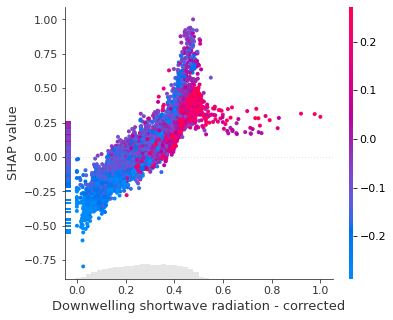

[CV] END ................................fit_intercept=False; total time=   3.7s
[CV 1/5] END colsample_bytree=1, gamma=0, learning_rate=0.05, max_depth=15, min_child_weight=10, subsample=0.8;, score=0.632 total time=  16.9s
[CV] END .................................fit_intercept=True; total time=   3.7s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV 5/5] END colsample_bytree=1, gamma=0, learning_rate=0.05, max_depth=15, min_child_weight=10, subsample=0.8;, score=0.613 total time=  18.2s
[CV 2/5] END l2_regularization=0, learning_rate=0.05, max_depth=15, max_iter=500, min_samples_leaf=10;, score=0.617 total time=   3.4s
[CV] END .................................fit_intercept=True; total time=   3.7s
[CV 5/5] END l2_regularization=0, learning_rate=0.05, max_depth=15, max_iter=500, min_samples_leaf=10;, score=0.607 total time=   3.4s
[CV] END .................................fit_intercept=True; total time=   3.7s
[CV] END ............................

In [56]:
# Create a new Explanation object with the SHAP values of the desired feature (6 in this case)
feature_6_shap_values = shap.Explanation(
    shap_values[:, 6].reshape(-1, 1),
    explainer.expected_value,
    X_set.loc[filter].values[:, 6].reshape(-1, 1),
    feature_names=[X_set.columns[6]]
)

# Use the SHAP values of another feature (7 in this case) as the color
color_values = shap_values[:, 7]

shap.plots.scatter(feature_6_shap_values, color=color_values)


-----------

<IPython.core.display.Javascript object>


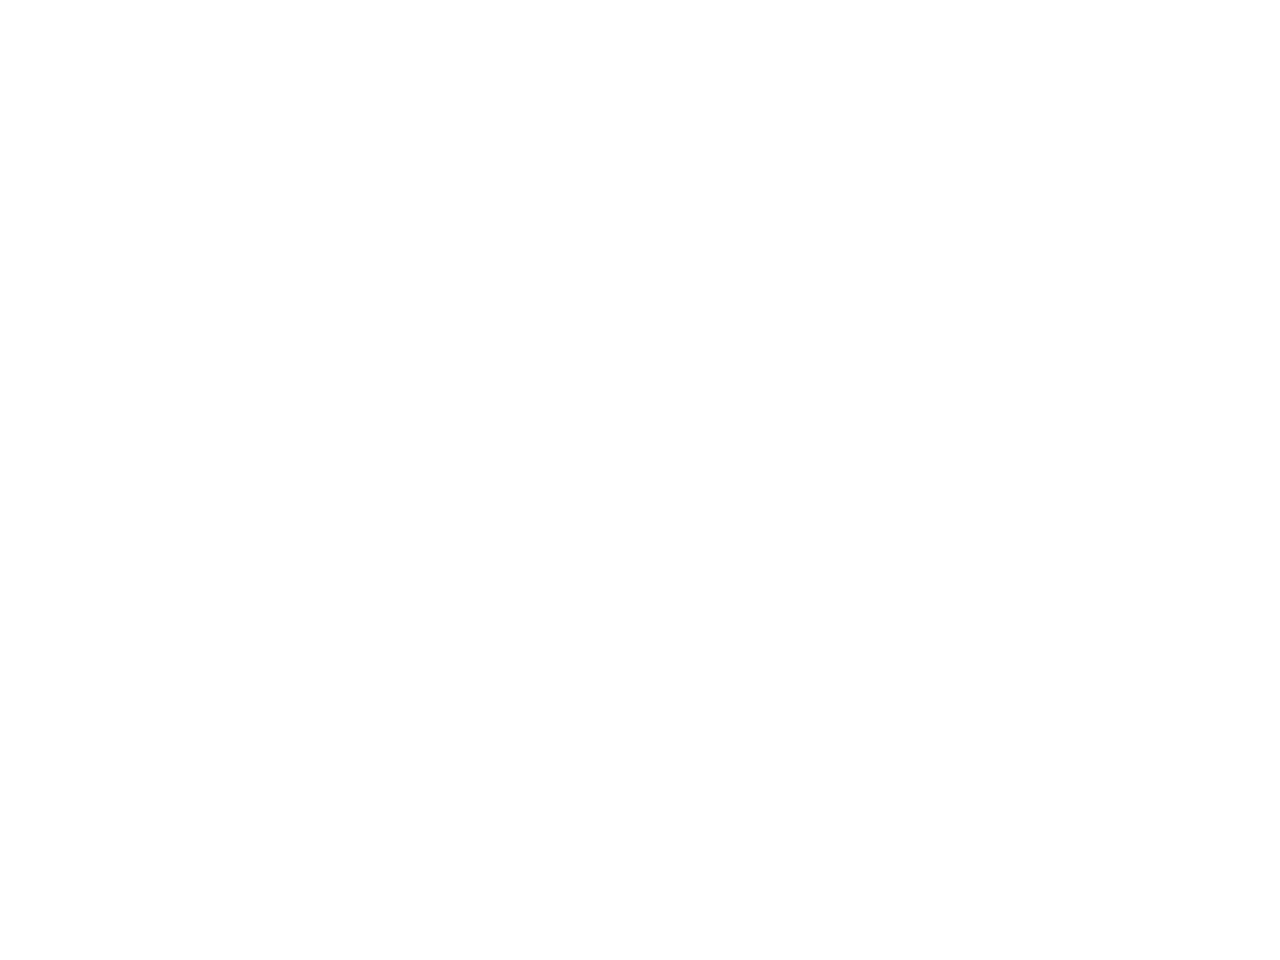

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

shap_values = pd.DataFrame(shap_values.values)
# Assuming you have SHAP values in a variable called shap_values
feature1_idx = 7  # Replace with the index of the first feature you want to explore
feature2_idx = 8  # Replace with the index of the second feature you want to explore

# Extract the SHAP values for the two features
shap_values_feature1 = shap_values.iloc[:, feature1_idx].values
shap_values_feature2 = shap_values.iloc[:, feature2_idx].values

# Extract the actual values of the two features from your dataset
# Replace `X` with your actual dataset
feature1_values = X.iloc[:, feature1_idx].values
feature2_values = X.iloc[:, feature2_idx].values

# Create the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1_values, feature2_values, shap_values_feature1, c='r', marker='o', s=1, label='Feature 1')
ax.scatter(feature1_values, feature2_values, shap_values_feature2, c='b', marker='o', s=1, label='Feature 2')

ax.set_xlabel('Feature 1 Value')
ax.set_ylabel('Feature 2 Value')
ax.set_zlabel('SHAP Value')
ax.legend()

plt.show()


<IPython.core.display.Javascript object>


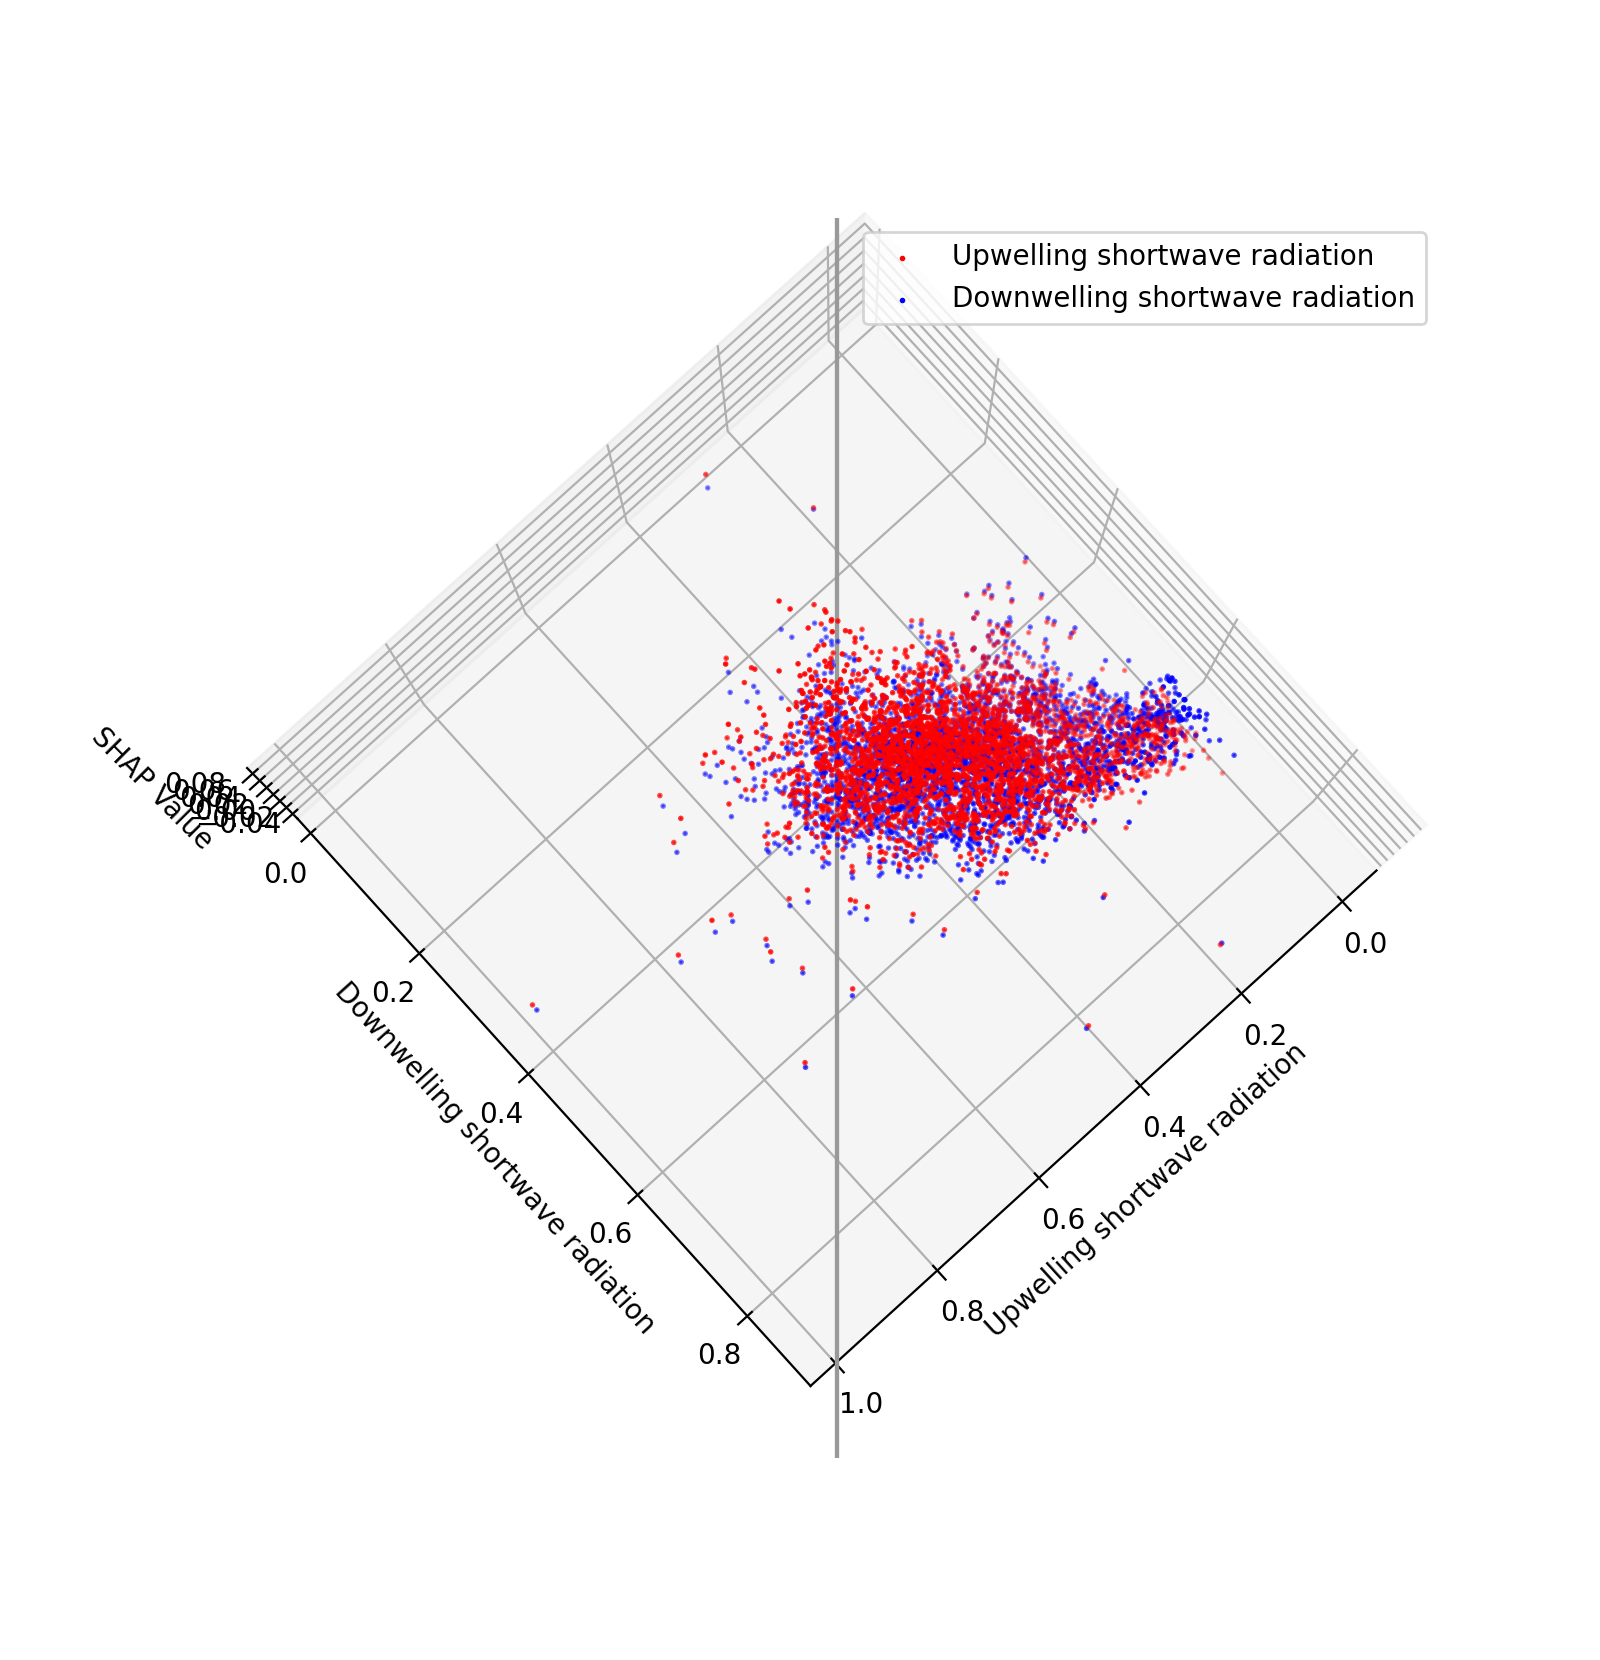

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Replace these with the actual column names
feature1_name = 'Upwelling shortwave radiation'
feature2_name = 'Downwelling shortwave radiation'

# If using Jupyter Notebook:
%matplotlib notebook

# If using JupyterLab, uncomment the following line and make sure you have ipympl installed:
# %matplotlib widget

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1_values, feature2_values, shap_values_feature1, c='r', marker='o', s=1,label=feature1_name)
ax.scatter(feature1_values, feature2_values, shap_values_feature2, c='b', marker='o', s=1, label=feature2_name)

ax.set_xlabel(feature1_name)
ax.set_ylabel(feature2_name)
ax.set_zlabel('SHAP Value')

ax.legend()
plt.show()


--------

In [ ]:
# Average SHAP values for the filtered indices
avg_shap_values = np.mean(shap_values.values, axis=0)

# Create a single-row DataFrame containing the average SHAP values
avg_shap_df = pd.DataFrame([avg_shap_values], columns=X.columns)

# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values=avg_shap_df.values,
    base_values= explainer.expected_value,
    data=X.loc[index_filter_first_melt_day].mean(axis=0).values.reshape(1, -1),
    feature_names=X.columns,
)

shap.initjs()
shap.force_plot(avg_explanation, matplotlib=False, plot_cmap = [positive_color, negative_color])

In [ ]:
shap.initjs()

positive_color = "#ca0020"
negative_color = "#92c5de"

shap.force_plot(explainer.expected_value, shap_values.values, X.loc[index_filter_first_melt_day], plot_cmap = [positive_color, negative_color])  


In [ ]:
clustering = shap.utils.hclust(X, y)
# Use mean absolute SHAP values for the bar plot
shap.plots.bar(mean_abs_shap_values, clustering=clustering)

In [ ]:
#shap.plots.partial_dependence("Albedo", eval(f"hist_model_{y}").predict, X, ice=False, model_expected_value=True, feature_expected_value=True)

shap_values_array = shap_values.values

shap.dependence_plot('Albedo', shap_values_array, X)



In [104]:
filter = filter

columns_to_remove = ["seasonal_residual"]
#X_set= df[[col for col in df.columns if col not in columns_to_remove]]
#y_set = df["seasonal_residual"]
X_set = pd.concat([X_train, X_test])
y_set = pd.concat([y_train, y_test])

X_set = X_set.loc[filter].reset_index(drop=False)
y = pd.DataFrame(y_set[filter]).reset_index(drop=True)
shap_values = explainer(X_set.iloc[:,1:])

## This bit to check credibility by R^2
y_pred = xgb_model_seasonal_residual.predict(X_set.iloc[:,1:])
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred, squared=True)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

## This bit to calculate the average X entries for -10/+10 days across all stations and years
#Filter by indices
#X = X_set.loc[filter].reset_index()
X =  X_set
# Merge date to group by year 
X_tempp = pd.merge(X, data[['Datetime', 'Ablation']], left_on='index', right_index=True)
X = pd.merge(X, data[['Datetime', 'Ablation']], left_on='index', right_index=True)
columns_to_remove = ['index']
X = X[[col for col in X.columns if col not in columns_to_remove]]
X['Year'] = X['Datetime'].dt.year
# Add predictions to be used in base values calculations
predictions = xgb_model_seasonal_residual.predict(X.iloc[:,:17])
X['predicted'] = predictions
X_temp = X
# Create a new column 'EntryNumber' to store the entry number for each year
X['EntryNumber'] = X.groupby(['stid', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
X = X.groupby('EntryNumber').mean().reset_index()
columns_to_remove = ['EntryNumber', 'Ablation', 'Year', 'predicted','stid_y']
X = X[[col for col in X.columns if col not in columns_to_remove]]

## This bit to calculate the average SHap values for -10/+10 days across all stations and years
avg_shap_df = pd.merge(pd.DataFrame(shap_values.values, columns= X.columns), X_tempp[['Datetime', "stid"]], left_index=True, right_index=True)
avg_shap_df['Datetime'] = pd.to_datetime(avg_shap_df['Datetime'])
# Extract the year from the DateTime column and create a new column 'Year'
avg_shap_df['Year'] = avg_shap_df['Datetime'].dt.year
# Create a new column 'EntryNumber' to store the entry number for each year
avg_shap_df['EntryNumber'] = avg_shap_df.groupby(['stid_y', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
avg_shap_df = avg_shap_df.groupby('EntryNumber').mean().reset_index()
# Drop unnecessary columns from the result
avg_shap_df = avg_shap_df[[col for col in avg_shap_df.columns if col not in columns_to_remove]]
avg_shap_df = avg_shap_df.reset_index(drop=True)

## This bit to calculate the base value (prediction of first row - sum of shap values for this day)
base = predictions[0] - np.sum(pd.DataFrame(avg_shap_df.values).iloc[0:1,:17], axis=1) 




# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values = avg_shap_df.values,
    base_values =  base[0], #base,#np.mean(xgb_model_seasonal_residual.predict(X_set.loc[filter])), #explainer.expected_value,
    data = X, #X.loc[filter].mean(axis=0).values.reshape(1, -1),
    feature_names = X.columns
)

shap.initjs()

positive_color = "#ca0020"
negative_color = "#92c5de"

key = [-x for x in range(start_day_first, 0, -1)] + list(range(end_day_first + 1))

force_plot = shap.force_plot(avg_explanation, X, plot_cmap = [positive_color, negative_color], ordering_keys=key)
#shap.save_html(r'../figures/SW/Results/SW_first_10.html', force_plot)

force_plot

R^2 score on test set:  0.8136668580056899
MSE on test set:  0.000660433525451023


KeyError: "None of [Index(['Datetime', 'Ablation'], dtype='object')] are in the [columns]"

In [ ]:
shap_values_array = avg_shap_df.values

shap.dependence_plot('Downwelling shortwave radiation - corrected', shap_values_array, X)


In [ ]:
X.columns

###### Last Melt Day

In [ ]:
X_set = pd.concat([X_train, X_test])
y_set = pd.concat([y_train, y_test])

index_filter_last_melt_day = indices_last_melt_day.to_list()

shap_values = explainer(X_set.loc[index_filter_last_melt_day])
mean_abs_shap_values = shap_values.abs.mean(0)
X = X_set.loc[index_filter_last_melt_day]
y = y_set[index_filter_last_melt_day]

In [ ]:
# Plot the SHAP summary plot using the shap.summary_plot() function for the subset of interest
shap.summary_plot(shap_values, X.loc[index_filter_last_melt_day], plot_type='bar')

In [ ]:
print("Top 5 Shapley values for the beginning of melting seasons")
shap.summary_plot(shap_values, X.loc[index_filter_last_melt_day], max_display=5 , plot_type="violin")

In [ ]:
# Average SHAP values for the filtered indices
avg_shap_values = np.mean(shap_values.values, axis=0)

# Create a single-row DataFrame containing the average SHAP values
avg_shap_df = pd.DataFrame([avg_shap_values], columns=X.columns)

# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values=avg_shap_df.values,
    base_values=explainer.expected_value,
    data=X.loc[index_filter_last_melt_day].mean(axis=0).values.reshape(1, -1),
    feature_names=X.columns,
)

positive_color = "#ca0020"
negative_color = "#92c5de"

shap.initjs()
shap.force_plot(avg_explanation, matplotlib=False, plot_cmap = [positive_color, negative_color])

In [ ]:
shap.initjs()
positive_color = "#ca0020"
negative_color = "#92c5de"
shap.force_plot(explainer.expected_value, shap_values.values, X.loc[index_filter_last_melt_day], plot_cmap = [positive_color, negative_color])



In [ ]:
clustering = shap.utils.hclust(X, y)
# Use mean absolute SHAP values for the bar plot
shap.plots.bar(mean_abs_shap_values, clustering=clustering)

In [ ]:
#shap.plots.partial_dependence("Albedo", eval(f"hist_model_{y}").predict, X, ice=False, model_expected_value=True, feature_expected_value=True)

shap_values_array = shap_values.values

shap.dependence_plot('Albedo', shap_values_array, X)



In [ ]:
filter = expanded_indices_last

columns_to_remove = ["seasonal_residual"]
X_set= df[[col for col in df.columns if col not in columns_to_remove]]
y_set = df["seasonal_residual"]

y = y_set[filter]
shap_values = explainer(X_set)

## This bit to check credibility by R^2
y_pred = hist_model_seasonal_residual.predict(X_set.loc[filter])
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred, squared=True)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

## This bit to calculate the average X entries for -10/+10 days across all stations and years
#Filter by indices
X = X_set.loc[filter]
# Merge date to group by year 
X = pd.merge(X, data[['Datetime', 'Ablation']], left_index=True, right_index=True)
X['Year'] = X['Datetime'].dt.year
# Add predictions to be used in base values calculations
predictions = hist_model_seasonal_residual.predict(X.iloc[:,:17])
X['predicted'] = predictions
X_temp = X
# Create a new column 'EntryNumber' to store the entry number for each year
X['EntryNumber'] = X.groupby(['stid', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
X = X.groupby('EntryNumber').mean().reset_index()
columns_to_remove = ['EntryNumber', 'Ablation', 'Year', 'predicted','stid_y']
X = X[[col for col in X.columns if col not in columns_to_remove]]

## This bit to calculate the average SHap values for -10/+10 days across all stations and years
avg_shap_df = pd.merge(pd.DataFrame(shap_values.values, columns= X.columns).loc[filter], data[['Datetime', "stid"]], left_index=True, right_index=True)
avg_shap_df['Datetime'] = pd.to_datetime(avg_shap_df['Datetime'])
# Extract the year from the DateTime column and create a new column 'Year'
avg_shap_df['Year'] = avg_shap_df['Datetime'].dt.year
# Create a new column 'EntryNumber' to store the entry number for each year
avg_shap_df['EntryNumber'] = avg_shap_df.groupby(['stid_y', 'Year']).cumcount() + 1
# Now, group the data by 'EntryNumber' and calculate the mean of each group
avg_shap_df = avg_shap_df.groupby('EntryNumber').mean().reset_index()
# Drop unnecessary columns from the result
avg_shap_df = avg_shap_df[[col for col in avg_shap_df.columns if col not in columns_to_remove]]
avg_shap_df = avg_shap_df.reset_index(drop=True)

## This bit to calculate the base value (prediction of first row - sum of shap values for this day)
base = predictions[0] - np.sum(pd.DataFrame(avg_shap_df.values).iloc[0:1,:17], axis=1) 




# Generate an Explanation object using the average SHAP values
avg_explanation = shap.Explanation(
    values = avg_shap_df.values,
    base_values =  base[0], #base,#np.mean(xgb_model_seasonal_residual.predict(X_set.loc[filter])), #explainer.expected_value,
    data = X, #X.loc[filter].mean(axis=0).values.reshape(1, -1),
    feature_names = X.columns
)

shap.initjs()

positive_color = "#ca0020"
negative_color = "#92c5de"

key = [-x for x in range(start_day_last, 0, -1)] + list(range(end_day_last + 1))

force_plot = shap.force_plot(avg_explanation, X, plot_cmap = [positive_color, negative_color], ordering_keys=key)

shap.save_html(r'../figures/SW/Results/SW_last_10.html', force_plot)

force_plot

-------